In [1]:
import time
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import yfinance as yf
import datetime
import os

In [2]:
general_stocks = ['KO', 'PFE', 'WMT', 'PG', 'JNJ', 'DIS', 'PEP', 'MCD', 'T', 'VZ']
tech_stocks = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'META', 'INTC', 'IBM', 'AMD']
finance_stocks = ['GS', 'BAC', 'WFC', 'USB', 'JPM', 'MA', 'V', 'AXP', 'C', 'BLK']
decentralized_currencies = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'XMR', 'LTC', 'SHIB']

general_stocks_names = ['Coca-Cola', 'Pfizer', 'Walmart', 'Procter & Gamble', 'Johnson & Johnson', 'Disney', 'Pepsi', 'McDonalds', 'AT&T', 'Verizon']
tech_stocks_names = ['Apple', 'Amazon', 'Microsoft', 'Google', 'Nvidia', 'Tesla', 'Meta', 'Intel', 'IBM', 'AMD']
finance_stocks_names = ['Goldman Sachs', 'Bank of America', 'Wells Fargo', 'US Bancorp', 'JPMorgan Chase', 'Mastercard', 'Visa', 'American Express', 'Citigroup', 'BlackRock']
decentralized_currencies_names = ['Bitcoin', 'Ethereum', 'Cardano', 'Binance Coin', 'Solana', 'Ripple', 'Dogecoin', 'Monero', 'Litecoin', 'Shiba Inu']

color_map = {
    'general': 'deepskyblue',
    'tech': 'limegreen',
    'finance': 'darkorchid',
    'crypto': 'red'
}

In [6]:
def get_trends_data(keyword, 
                    timeframe=datetime.date.today().strftime('%Y-%m-%d') + ' ' + (datetime.date.today() - datetime.timedelta(days = 269)).strftime('%Y-%m-%d'),
                    retries=5, 
                    backoff_factor=1.0):
    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), )
    pytrends.build_payload(keyword, cat = 0, timeframe = timeframe, geo='')
    
    for i in range(retries):
        try:
            df = pytrends.interest_over_time()
            if df is not None and not df.empty:
                print(f"Trend Data for {keyword} retrieved successfully.")
                df.reset_index(inplace = True)
                df.rename(columns = {'date': 'Date', keyword[0]: 'Trend'}, inplace = True)
                df['Date'] = pd.to_datetime(df['Date'].dt.strftime('%m/%d/%Y'))
                return df
            else:
                print("No data retrieved or DataFrame is empty.")
                return None
        except Exception as e:
            if "429" in str(e):
                sleep_time = backoff_factor * (2 ** i)
                print(f"Rate limit exceeded. Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                raise(f"An error occurred: {e}")
    print("Failed to retrieve data after several retries.")
    return None

def get_stock_data(ticker, start, end):
    currTicker = yf.Ticker(ticker)
    tickerDF = currTicker.history(repair = True, start = start, end = end, auto_adjust = False).drop(columns = ['Dividends', 'Stock Splits', 'Repaired?']).reset_index()
    print(f"Stock Data for {ticker} retrieved successfully.")
    tickerDF['Date'] = pd.to_datetime(tickerDF['Date'].dt.strftime('%m/%d/%Y'))
    return tickerDF

def trend_corr(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        if stock in decentralized_currencies:
            p = get_stock_data(f'{stock}-USD', start = start, end = end)
        else:
            p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    for i in range(1, 8):
        full_data[f'Delay_{i}'] = full_data['Trend'].shift(i)

    rho = full_data.corr()
    rho_c = rho['Close'][f'Delay_{delay}']
    return rho_c, full_data

def plot_stock_data(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7, download = False):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    full_data[f'Delay_{delay}'] = full_data.Trend.shift(7)

    # Determine the color based on the stock category
    if stock in general_stocks:
        color = color_map['general']
        name = general_stocks_names[general_stocks.index(stock)]
    elif stock in tech_stocks:
        color = color_map['tech']
        name = tech_stocks_names[tech_stocks.index(stock)]
    elif stock in finance_stocks:
        color = color_map['finance']
        name = finance_stocks_names[finance_stocks.index(stock)]
    else:
        color = color_map['crypto']
        name = decentralized_currencies_names[decentralized_currencies.index(stock)]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot Close price
    axes[0].plot(full_data['Date'], full_data['Close'], label = 'Close Price', color = color)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Close Price')
    axes[0].set_title(f'{stock}: Close Price')
    legend = axes[0].legend(loc='upper left')
    legend.get_frame().set_alpha(0.3)

    # Plot 7-days delay trend
    axes[1].plot(full_data['Date'], full_data[f'Delay_{delay}'], label = f'{delay}-Days Delayed Trend', color = 'black')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel(f'{delay}-Days Delayed Trend')
    axes[1].set_title(f'{stock}: {delay}-Days Delayed Trend')
    legend = axes[1].legend(loc='upper right')
    legend.get_frame().set_alpha(0.3)

    fig.suptitle(f'{name} ({stock})', fontsize=20, verticalalignment = 'bottom', fontweight = 'bold')
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.95)
    if download:
        plt.savefig(f"./Plots/{stock}_plot({start} - {end}).png", bbox_inches='tight')
    plt.show()

In [ ]:
start = '2022-09-01'
end = '2023-04-01'
stock = 'BTC'
name = 'Bitcoin'

if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
    t2 = get_trends_data([name], timeframe = f"{start} {end}")
    if t2 is None:
        raise Exception(f'Failed to retrieve Trend Data of {stock}.')
    t2.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
else:
    t2 = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")

start = '2023-03-01'
end = '2023-10-01'

if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
    t1 = get_trends_data([name], timeframe = f"{start} {end}")
    if t1 is None:
        raise Exception(f'Failed to retrieve Trend Data of {stock}.')
    t1.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
else:
    t1 = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")

t1.Date = pd.to_datetime(t1.Date)
t2.Date = pd.to_datetime(t2.Date)
max_date_t1 = t1.Date[t1.Trend == 100].iloc[0]
max_date_t2 = t2.Date[t2.Trend == 100].iloc[0]
#print(max_date_t1.iloc[0] == max_date_t2.iloc[0])


if max_date_t1 == max_date_t2:
     t1 = pd.concat([t1, t2], axis = 0)
     print(t1)
else:
    x = t2.Trend[max_date_t1]/100
    t1.Trend = t1.Trend * x
    t1 = pd.concat([t1, t2], axis = 0)
    print(t1)


$$Normalized\;Value=\frac{search\;value\;for\;term}{total\;Search\;Volume} * 100$$

and then each one devided by the max

In [12]:
glmpsBitcoin = pd.read_csv('Data/glimpse_Bitcoin_5Y.csv')

breakpoints = ['2019-06-23', '2020-02-23', '2020-10-23', 
               '2021-06-23', '2022-02-23', '2022-10-23', 
               '2023-06-23', '2024-02-23', '2024-06-23']

bitcoinDFs = []

for i in range(8):
    start = breakpoints[i]
    end = breakpoints[i+1]
    if not os.path.exists(f"./Data/Bitcoin_trends({start} - {end}).csv"):
        t = get_trends_data(['Bitcoin'], timeframe = f"{start} {end}")
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/Bitcoin_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/Bitcoin_trends({start} - {end}).csv")
    bitcoinDFs.append(t)

Trend Data for ['Bitcoin'] retrieved successfully.
Trend Data for ['Bitcoin'] retrieved successfully.
Trend Data for ['Bitcoin'] retrieved successfully.
Trend Data for ['Bitcoin'] retrieved successfully.
Trend Data for ['Bitcoin'] retrieved successfully.
Trend Data for ['Bitcoin'] retrieved successfully.
Trend Data for ['Bitcoin'] retrieved successfully.
Trend Data for ['Bitcoin'] retrieved successfully.


In [14]:
display(glmpsBitcoin)
display(Bitcoindf19_06)
display(Bitcoindf20_02)
display(Bitcoindf20_10)
display(Bitcoindf21_06)
display(Bitcoindf22_02)
display(Bitcoindf22_10)
display(Bitcoindf23_10)
display(Bitcoindf24_02)

Time (week of)  Normalized Value (0-100)  Absolute Google Search Volume
0       23/06/2019                        32                        3066880
1       30/06/2019                        22                        2108480
2       07/07/2019                        20                        1916800
3       14/07/2019                        21                        2012640
4       21/07/2019                        17                        1629280
..             ...                       ...                            ...
257     26/05/2024                        20                        1916800
258     02/06/2024                        23                        2204320
259     09/06/2024                        20                        1916800
260     16/06/2024                        19                        1820960
261     23/06/2024                        21                        2012640

[262 rows x 3 columns]

Date  Trend  isPartial
0   2019-06-23     50      False
1   2019-06-24     51      False
2   2019-06-25     59      False
3   2019-06-26    100      False
4   2019-06-27     84      False
..         ...    ...        ...
241 2020-02-19     30      False
242 2020-02-20     30      False
243 2020-02-21     27      False
244 2020-02-22     23      False
245 2020-02-23     25      False

[246 rows x 3 columns]

Date  Trend  isPartial
0   2020-02-23     29      False
1   2020-02-24     34      False
2   2020-02-25     32      False
3   2020-02-26     37      False
4   2020-02-27     35      False
..         ...    ...        ...
239 2020-10-19     29      False
240 2020-10-20     33      False
241 2020-10-21     50      False
242 2020-10-22     54      False
243 2020-10-23     44      False

[244 rows x 3 columns]

Date  Trend  isPartial
0   2020-10-23     12      False
1   2020-10-24     10      False
2   2020-10-25     10      False
3   2020-10-26     10      False
4   2020-10-27     12      False
..         ...    ...        ...
239 2021-06-19     21      False
240 2021-06-20     24      False
241 2021-06-21     33      False
242 2021-06-22     45      False
243 2021-06-23     32      False

[244 rows x 3 columns]

Date  Trend  isPartial
0   2021-06-23     62      False
1   2021-06-24     53      False
2   2021-06-25     52      False
3   2021-06-26     49      False
4   2021-06-27     47      False
..         ...    ...        ...
241 2022-02-19     36      False
242 2022-02-20     40      False
243 2022-02-21     45      False
244 2022-02-22     49      False
245 2022-02-23     40      False

[246 rows x 3 columns]

Date  Trend  isPartial
0   2022-02-23     36      False
1   2022-02-24     73      False
2   2022-02-25     50      False
3   2022-02-26     37      False
4   2022-02-27     38      False
..         ...    ...        ...
238 2022-10-19     20      False
239 2022-10-20     20      False
240 2022-10-21     20      False
241 2022-10-22     16      False
242 2022-10-23     17      False

[243 rows x 3 columns]

Date  Trend  isPartial
0   2022-10-23     29      False
1   2022-10-24     32      False
2   2022-10-25     35      False
3   2022-10-26     40      False
4   2022-10-27     35      False
..         ...    ...        ...
239 2023-06-19     34      False
240 2023-06-20     35      False
241 2023-06-21     49      False
242 2023-06-22     44      False
243 2023-06-23     45      False

[244 rows x 3 columns]

Date  Trend  isPartial
0   2023-06-23     36      False
1   2023-06-24     32      False
2   2023-06-25     30      False
3   2023-06-26     32      False
4   2023-06-27     30      False
..         ...    ...        ...
241 2024-02-19     37      False
242 2024-02-20     40      False
243 2024-02-21     36      False
244 2024-02-22     34      False
245 2024-02-23     32      False

[246 rows x 3 columns]

Date  Trend  isPartial
0   2024-02-23     30      False
1   2024-02-24     29      False
2   2024-02-25     30      False
3   2024-02-26     37      False
4   2024-02-27     63      False
..         ...    ...        ...
117 2024-06-19     26      False
118 2024-06-20     27      False
119 2024-06-21     28      False
120 2024-06-22     23      False
121 2024-06-23     23      False

[122 rows x 3 columns]

In [23]:
total1 = t1['Trend'].sum()
total2 = t2['Trend'].sum()

t1['Normalized'] = t1['Trend'] / total1 * 100
t2['Normalized'] = t2['Trend'] / total2 * 100

t1[]

# print(t1[t1['Date'] == '2023-10-03']['Trend'].values[0] / t2[t2['Date'] == '2023-10-03']['Trend'].values[0])
# print(t1[t1['Date'] == '2023-10-02']['Trend'].values[0] / t2[t2['Date'] == '2023-10-02']['Trend'].values[0])
# print(t1[t1['Date'] == '2023-10-01']['Trend'].values[0] / t2[t2['Date'] == '2023-10-01']['Trend'].values[0])

2.391304347826087
2.2222222222222223
2.3


In [4]:
# Calculate correlations for each category
volt_del_corr_general = [trend_corr(stock)[0] for stock in general_stocks]
volt_del_corr_tech = [trend_corr(stock)[0] for stock in tech_stocks]
volt_del_corr_finance = [trend_corr(stock)[0] for stock in finance_stocks]
volt_del_corr_crypto = [trend_corr(crypto)[0] for crypto in decentralized_currencies]

# Combine the results
volt_del_corr = volt_del_corr_general + volt_del_corr_tech + volt_del_corr_finance + volt_del_corr_crypto

# Create labels for the scatter plot
labels = general_stocks + tech_stocks + finance_stocks + decentralized_currencies

Trend Data for ['Shiba Inu'] retrieved successfully.
Stock Data for SHIB-USD retrieved successfully.


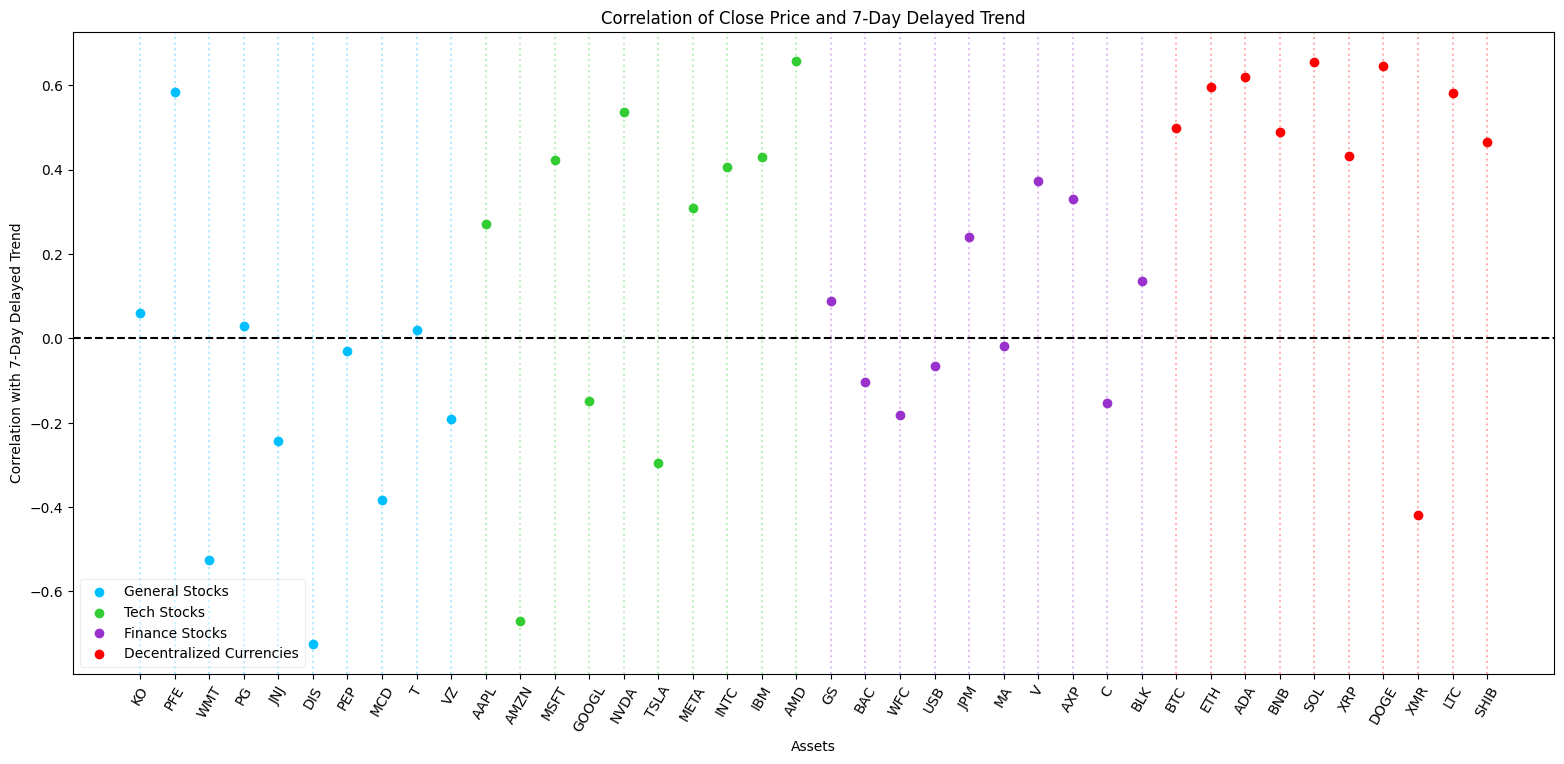

[0.06083405922601065, 0.5846259126983364, -0.5259142462478792, 0.029484131790527165, -0.24419562249497787, -0.7257889959088146, -0.02913030406575904, -0.38449128728090776, 0.019109268319779892, -0.19128968673210112, 0.27175113966373393, -0.670454918482103, 0.4224178611415635, -0.14787151816675623, 0.5375432207012999, -0.29517738855178394, 0.30912486748206647, 0.406255806049876, 0.430535507816767, 0.6572305397566136, 0.08914637783106535, -0.10328942855415923, -0.18079564007504664, -0.06510270094804174, 0.2391151450426618, -0.017164869146680244, 0.3733623128988734, 0.33000818659261993, -0.15319345391499065, 0.13514170192391917, 0.4992651195428232, 0.5964794700321365, 0.6195339971586918, 0.4901383786107852, 0.6544502266089904, 0.4314400816230174, 0.6455947636428416, -0.41835697957672224, 0.5821555428632512, 0.46630455179778124] 0.14322077826673274


In [11]:
# Plot the scatter plot
plt.figure(figsize=(16, 8))
plt.scatter(range(len(general_stocks)), volt_del_corr_general, color = color_map['general'], label = 'General Stocks')
for i in range(len(general_stocks)):
    plt.axvline(x = i, color = color_map['general'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks), len(general_stocks) + len(tech_stocks)), volt_del_corr_tech, color = color_map['tech'], label = 'Tech Stocks')
for i in range(len(general_stocks), len(general_stocks) + len(tech_stocks)):
    plt.axvline(x = i, color = color_map['tech'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)), volt_del_corr_finance, color = color_map['finance'], label = 'Finance Stocks')
for i in range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)):
    plt.axvline(x = i, color = color_map['finance'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)), volt_del_corr_crypto, color = color_map['crypto'], label = 'Decentralized Currencies')
for i in range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)):
    plt.axvline(x = i, color = color_map['crypto'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.axhline(y = 0, color = 'black', linestyle = '--')  # Add a horizontal line at y = 0
plt.xlabel('Assets')
plt.ylabel('Correlation with 7-Day Delayed Trend')
plt.title('Correlation of Close Price and 7-Day Delayed Trend')
legend = plt.legend()
legend.get_frame().set_alpha(0.3)
plt.xticks(range(len(labels)), labels, rotation = 60)
plt.tight_layout(pad = 2)
plt.savefig('Correlation_Scatter_Plot.png')
plt.show()

# Print the correlation values and their mean
print(volt_del_corr, np.mean(volt_del_corr))

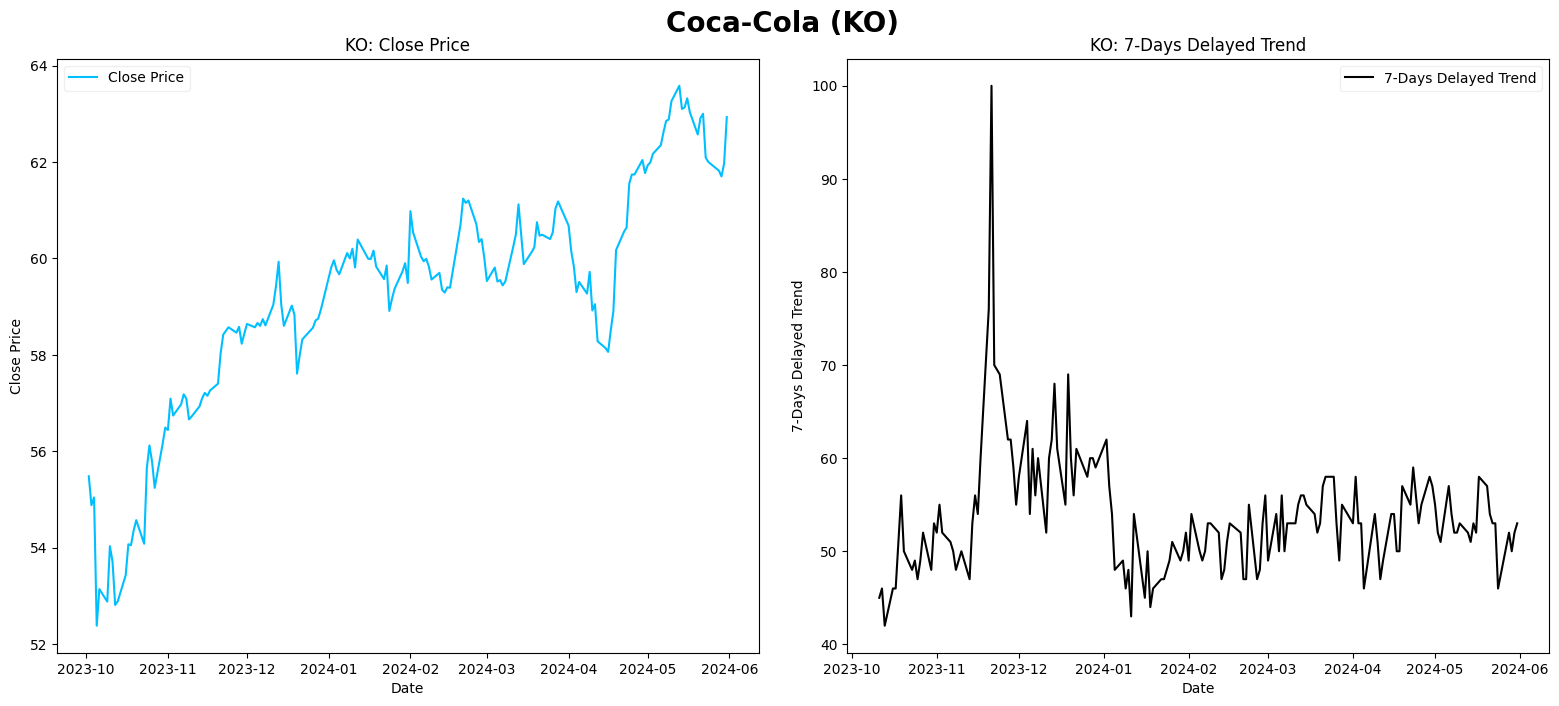

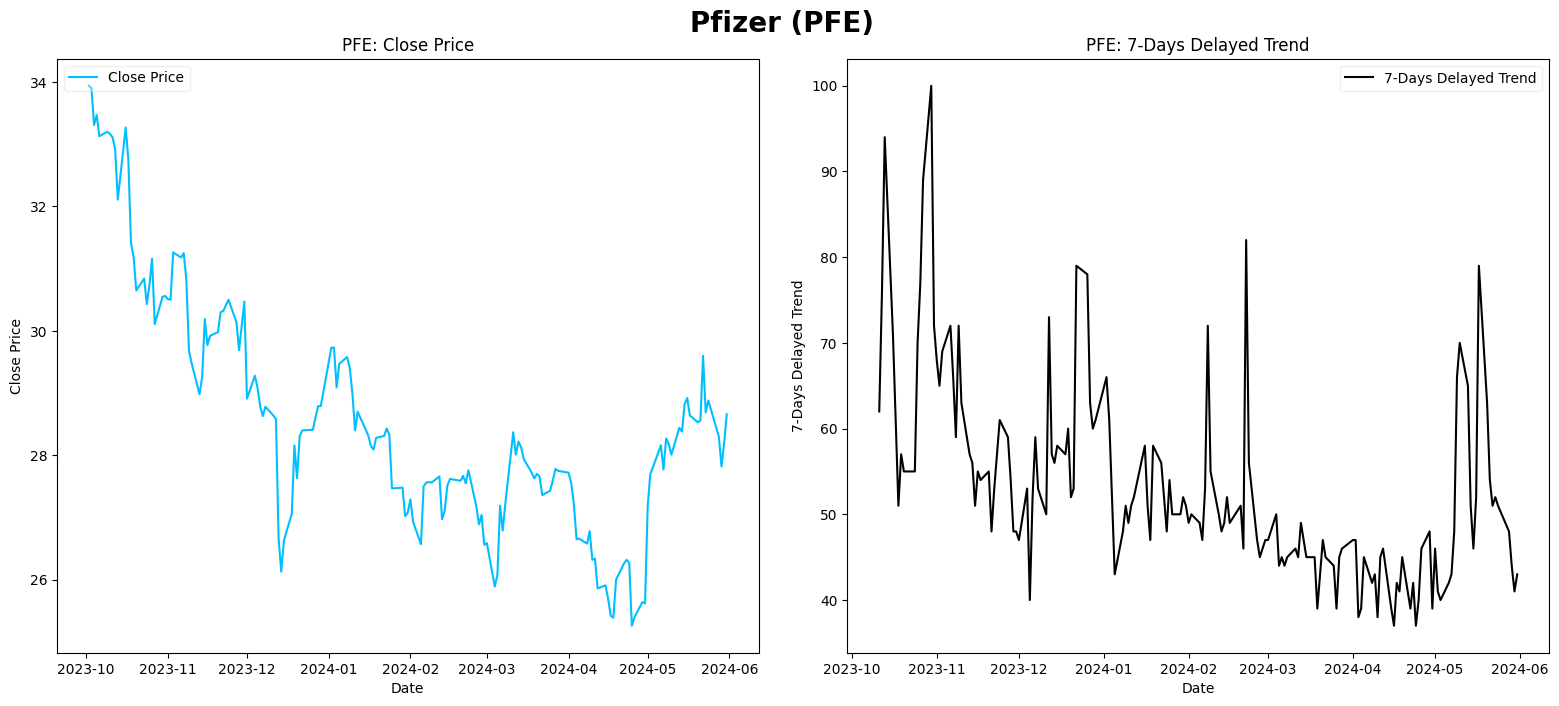

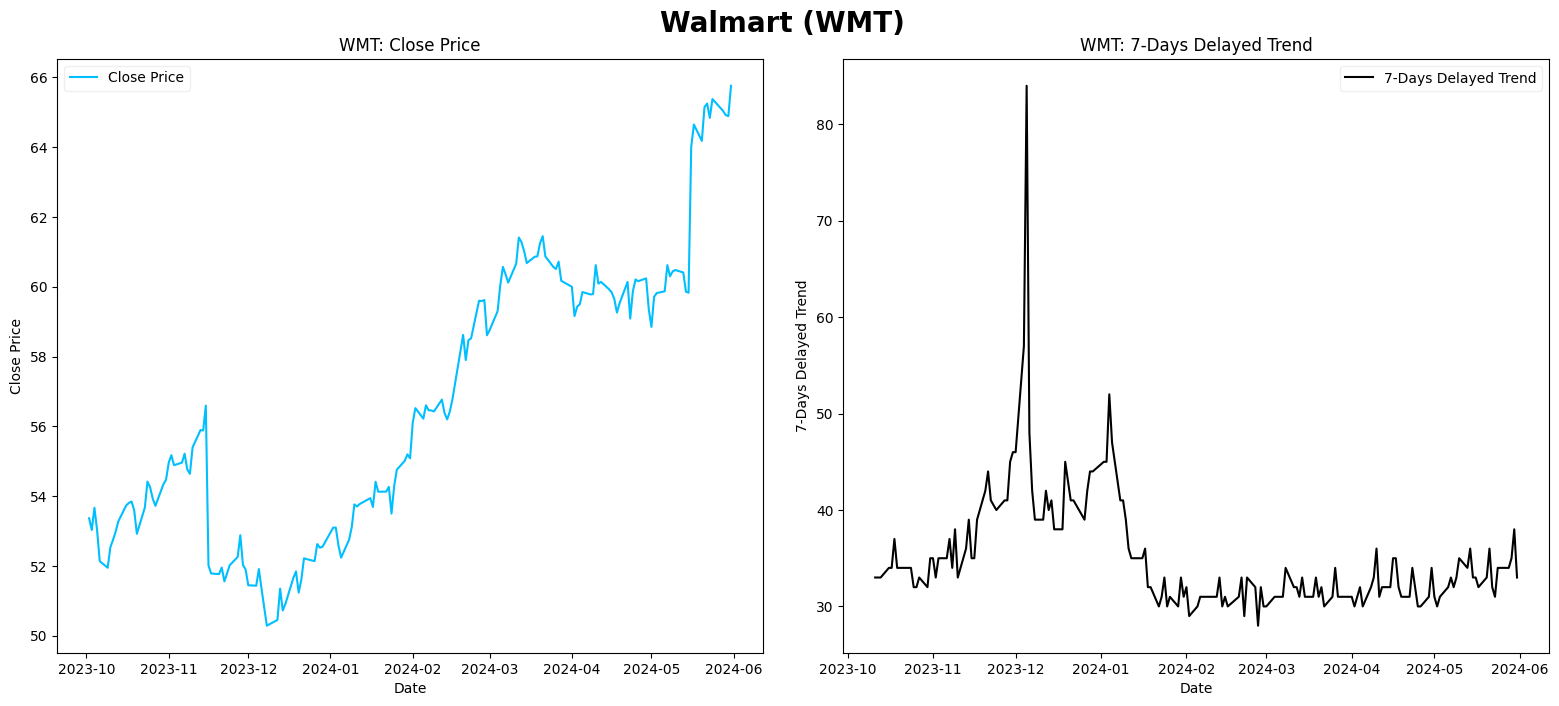

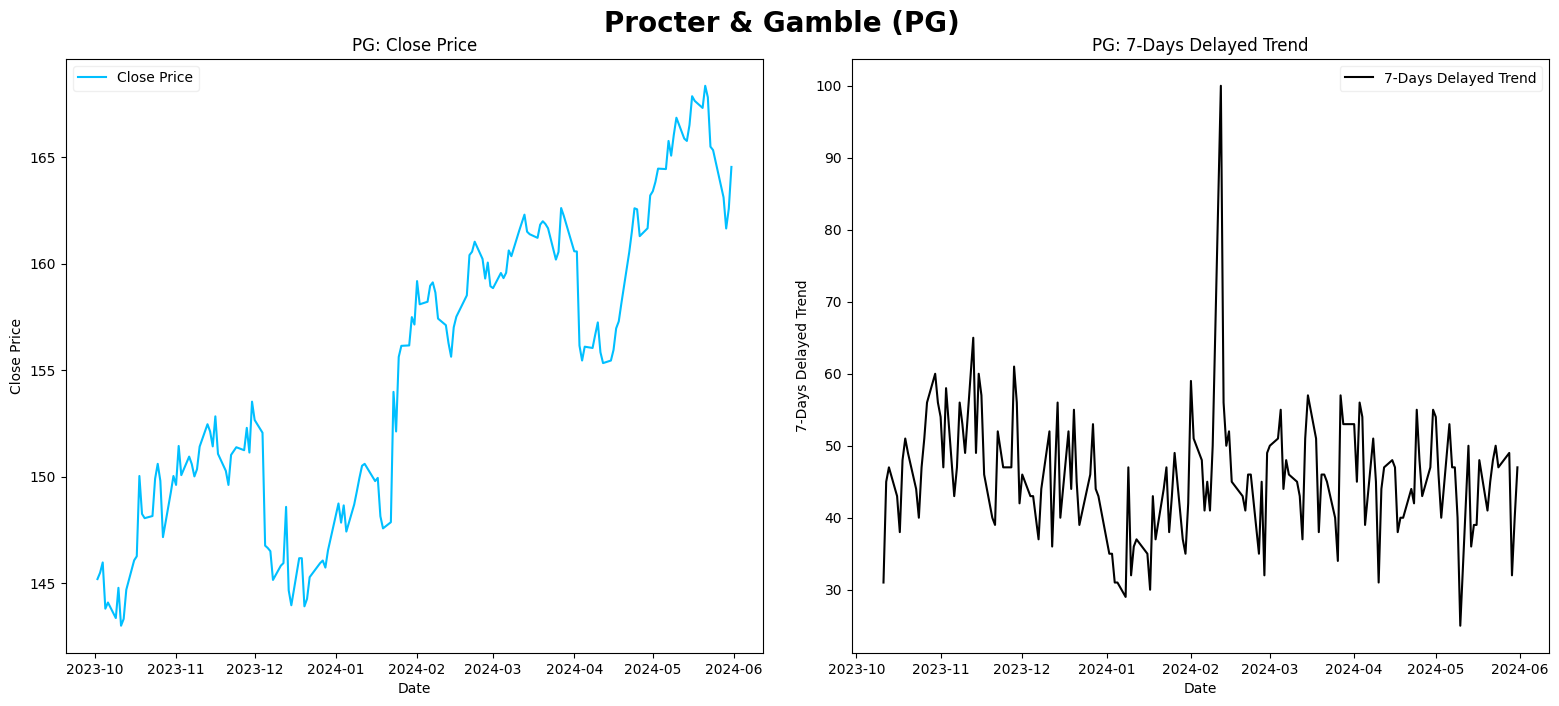

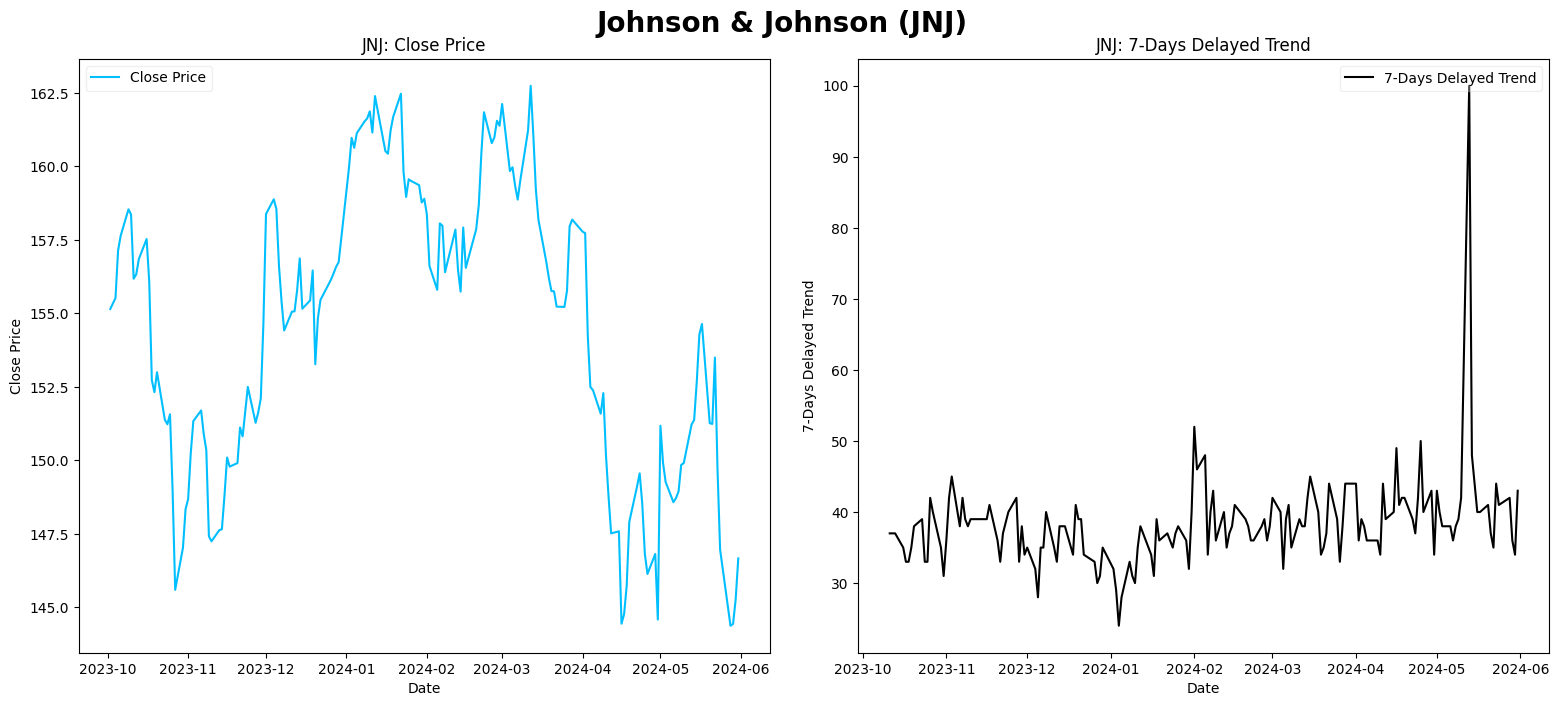

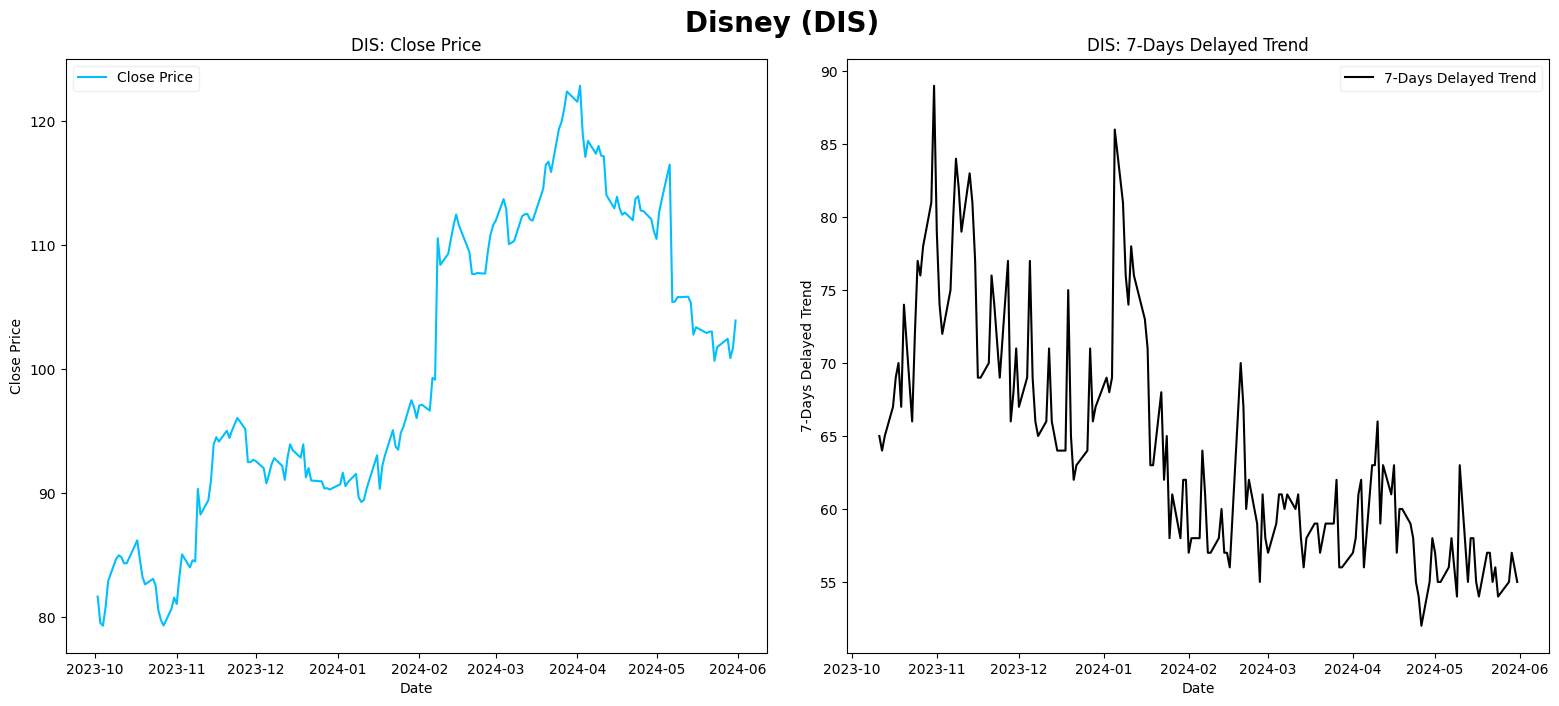

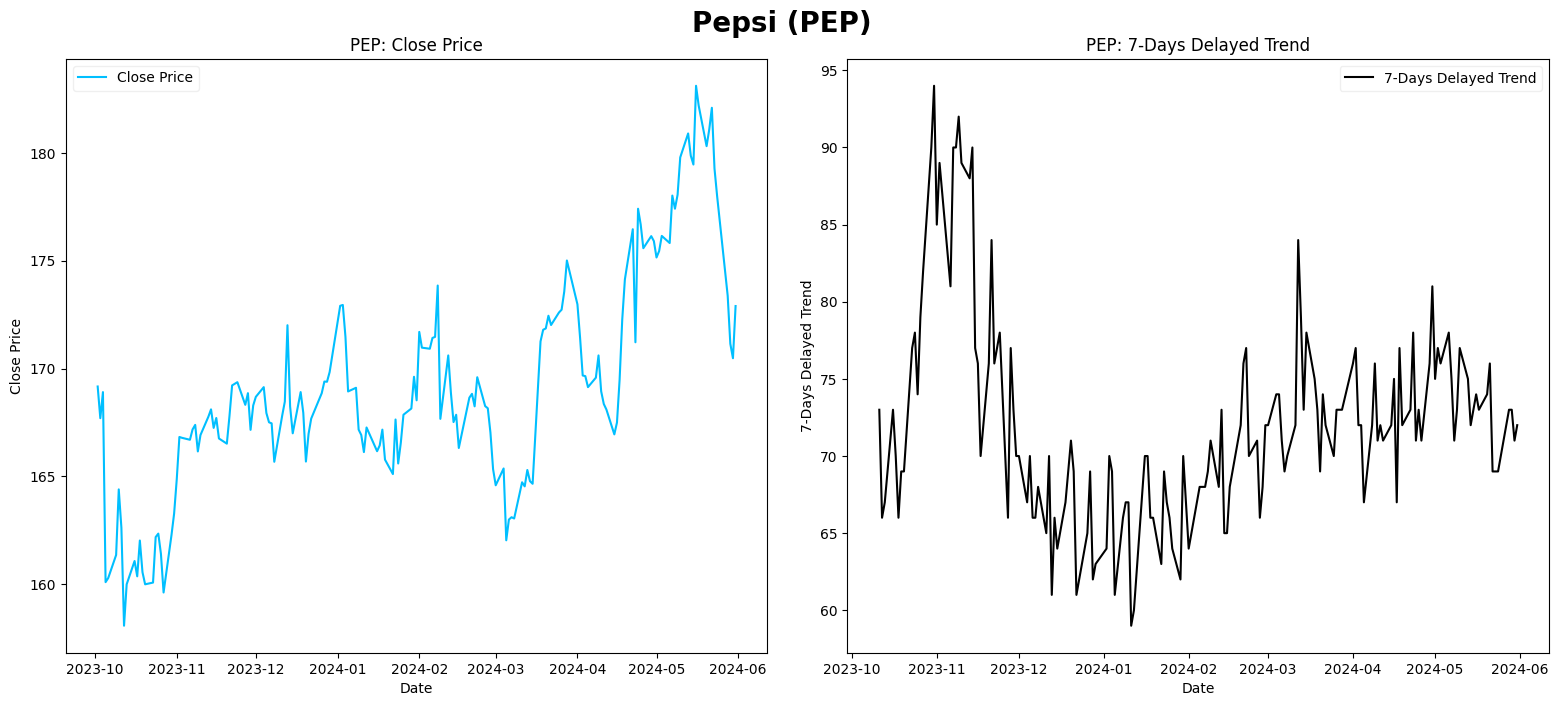

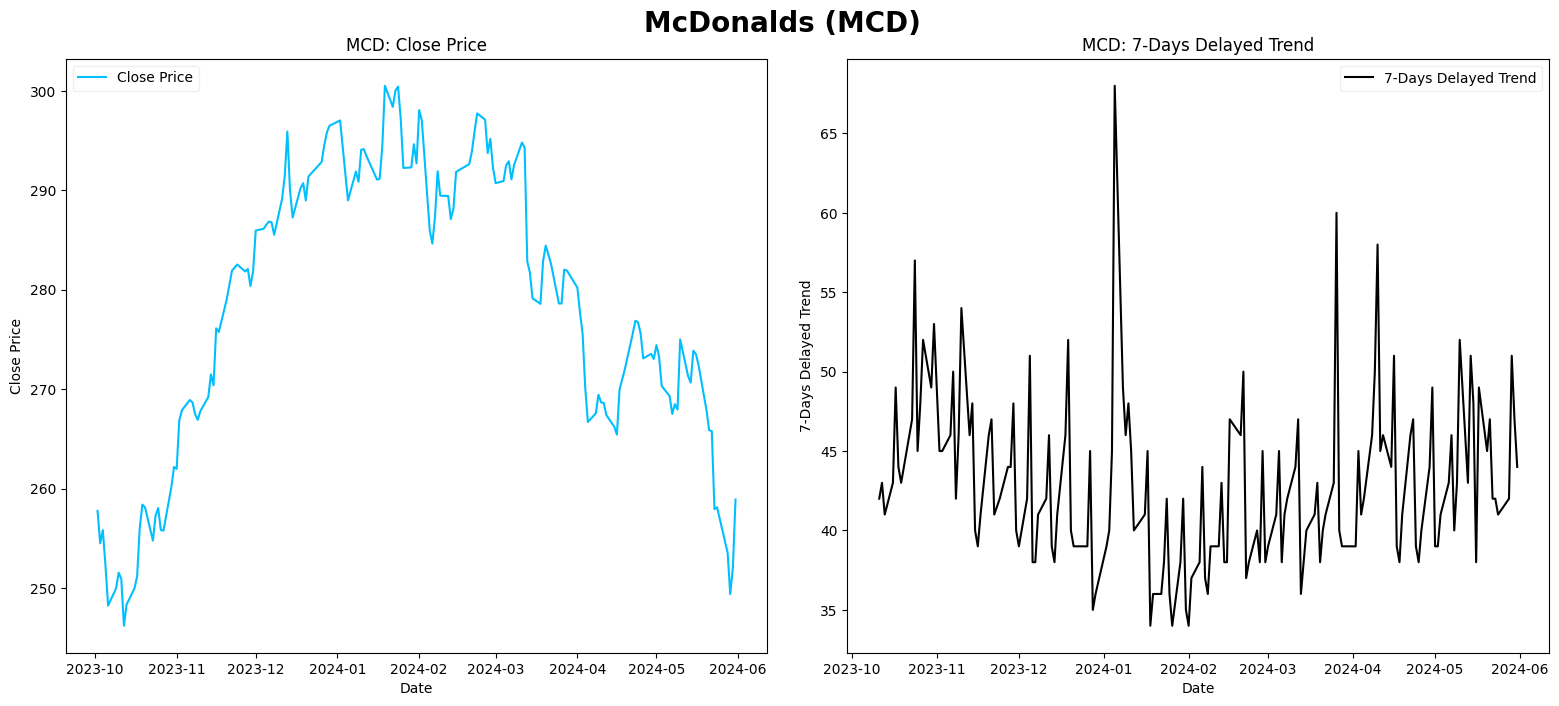

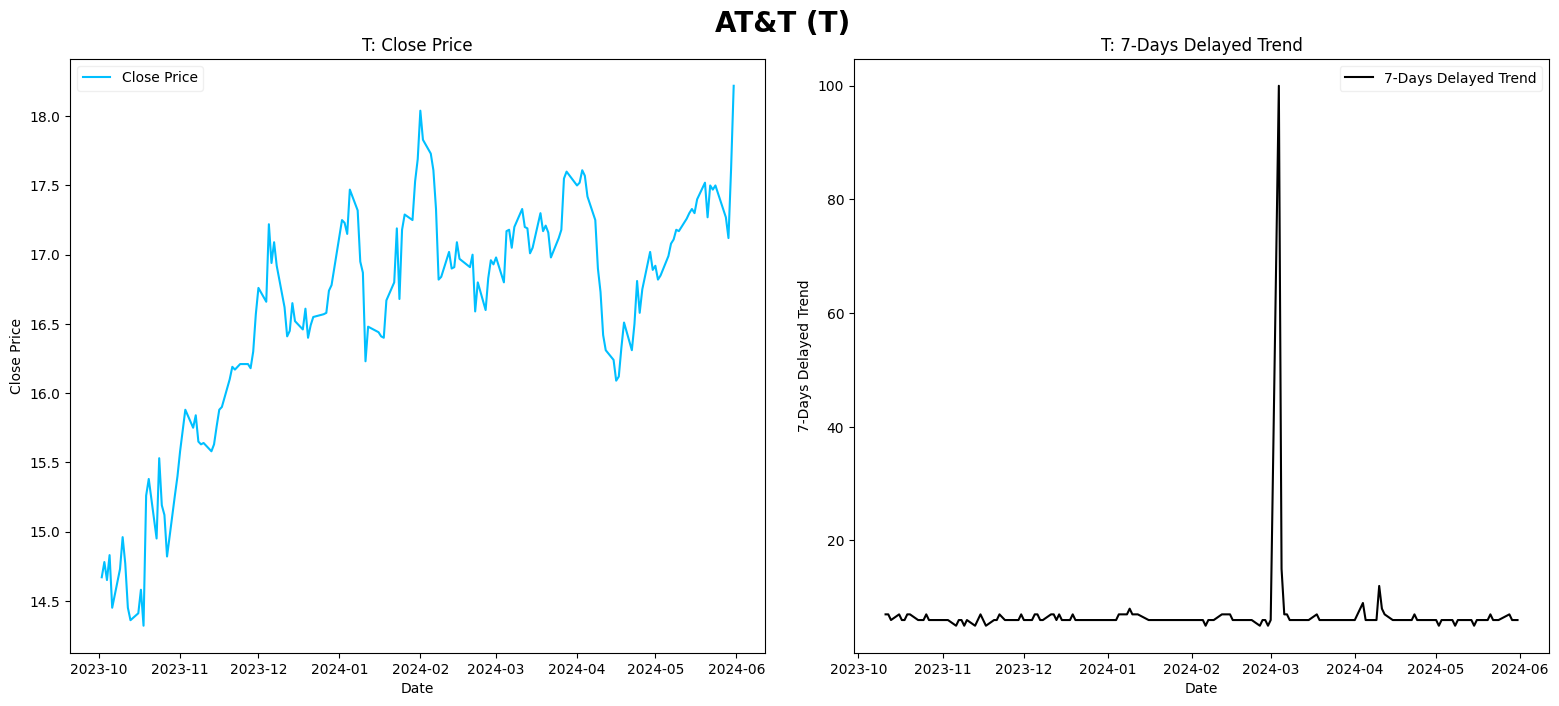

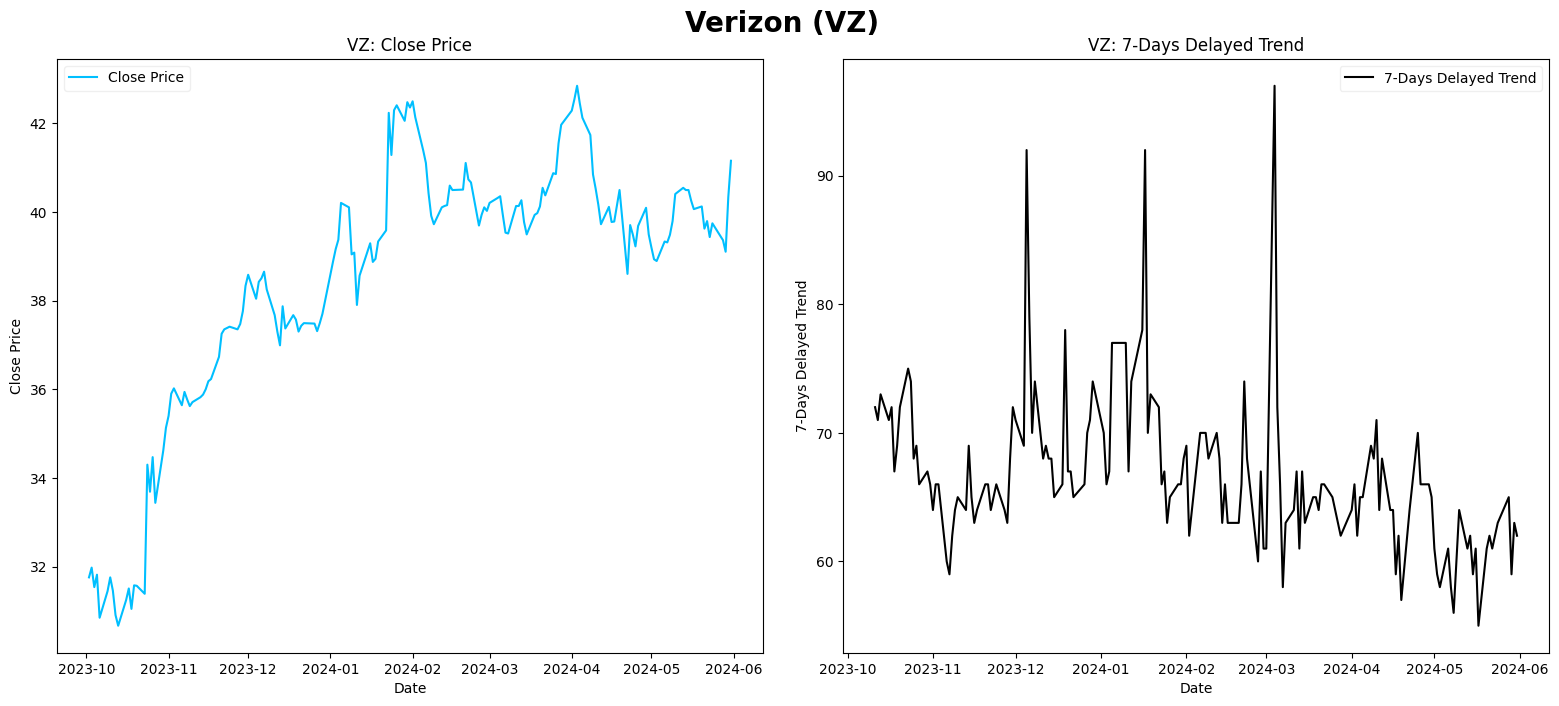

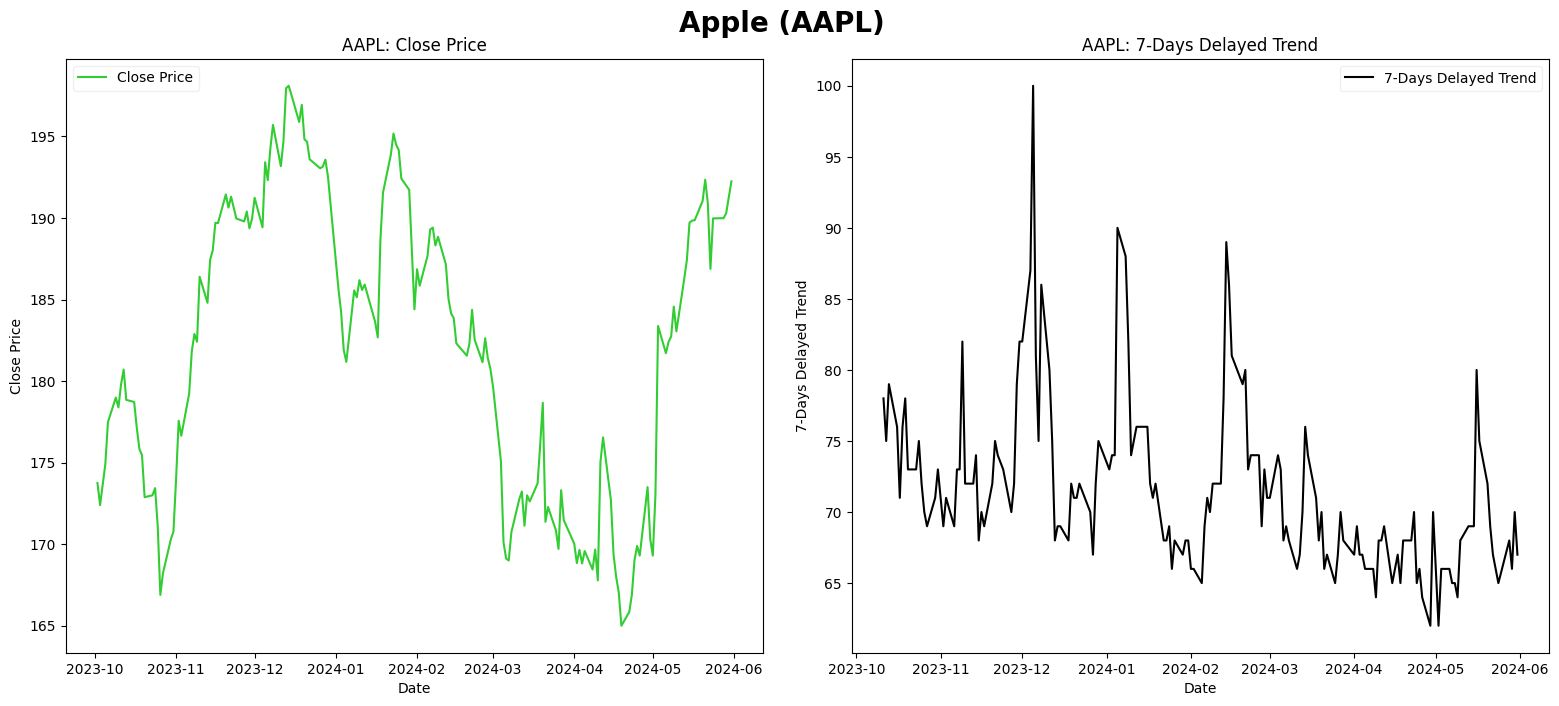

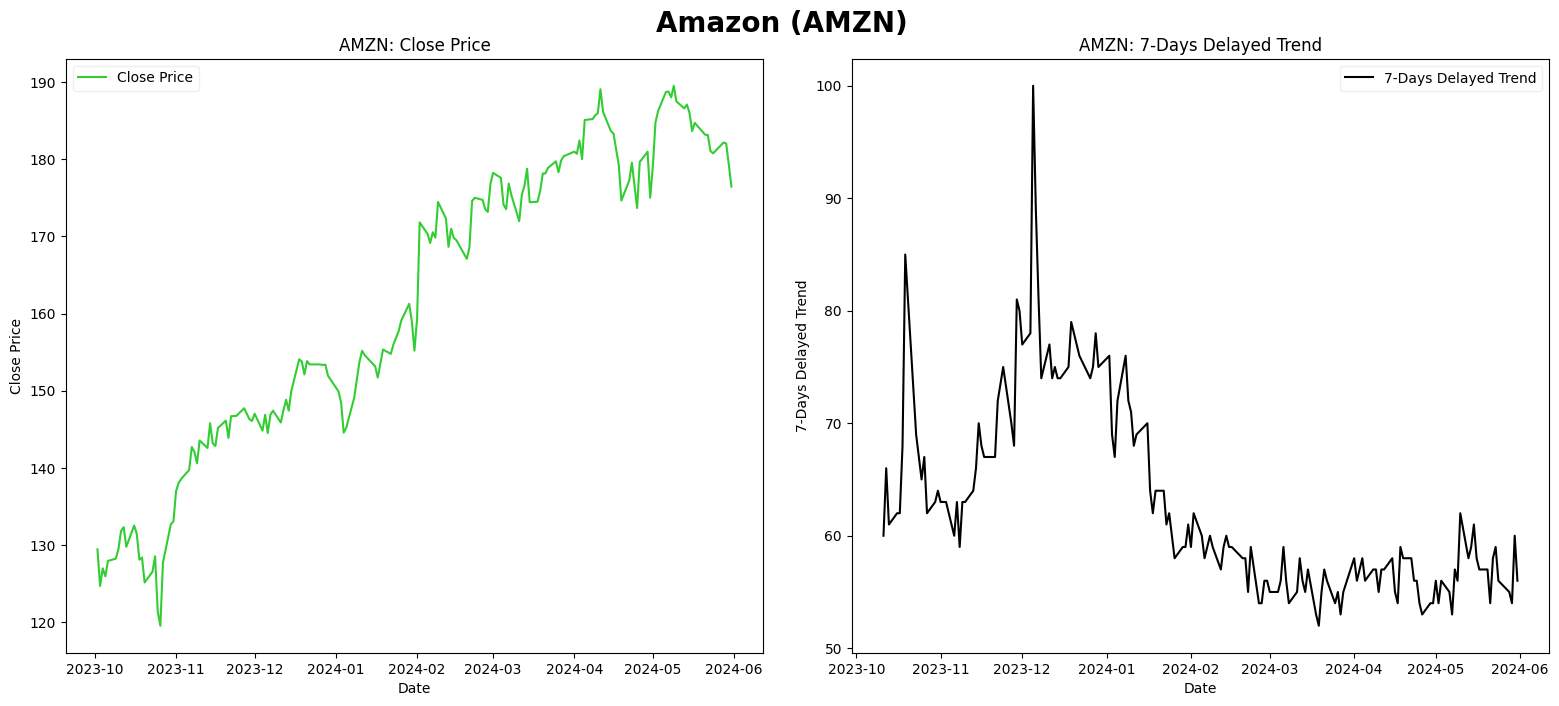

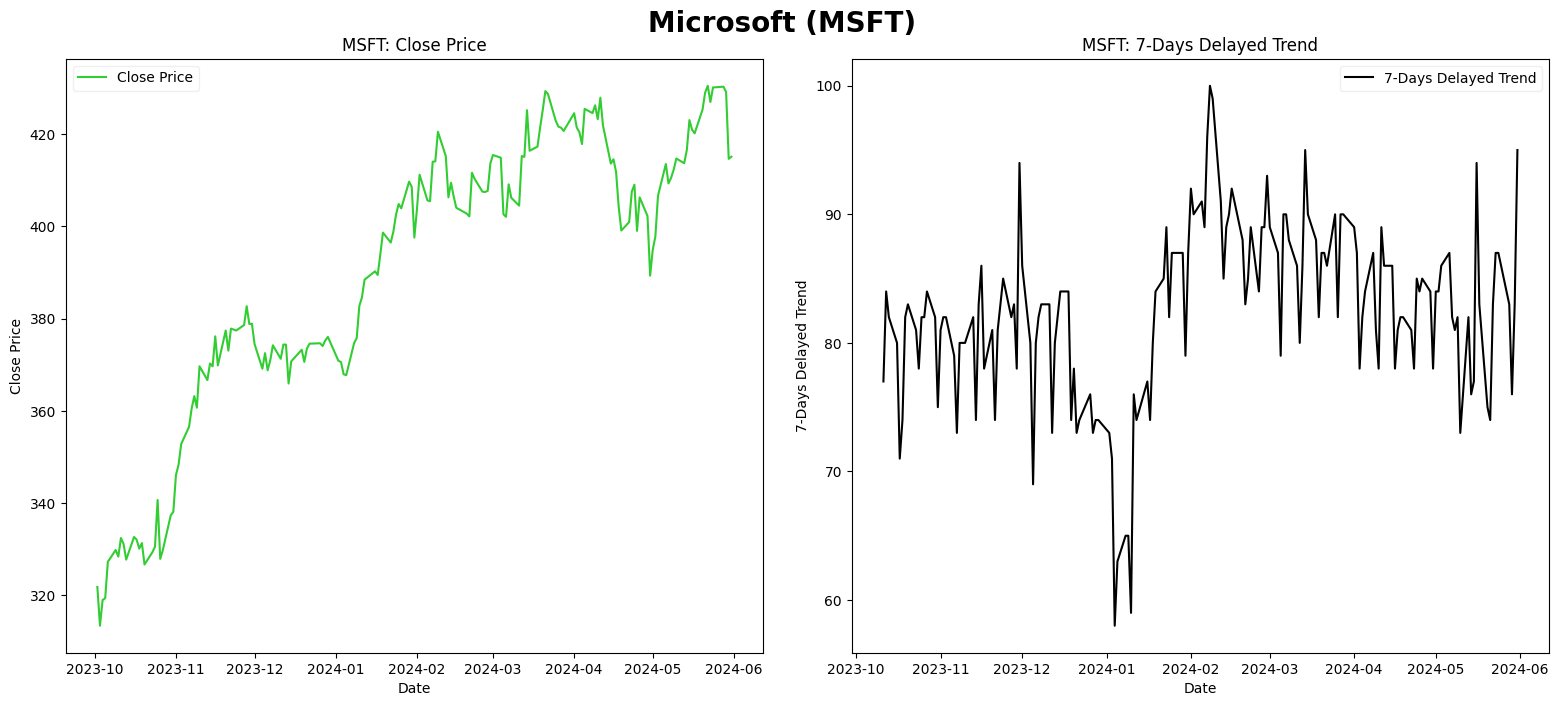

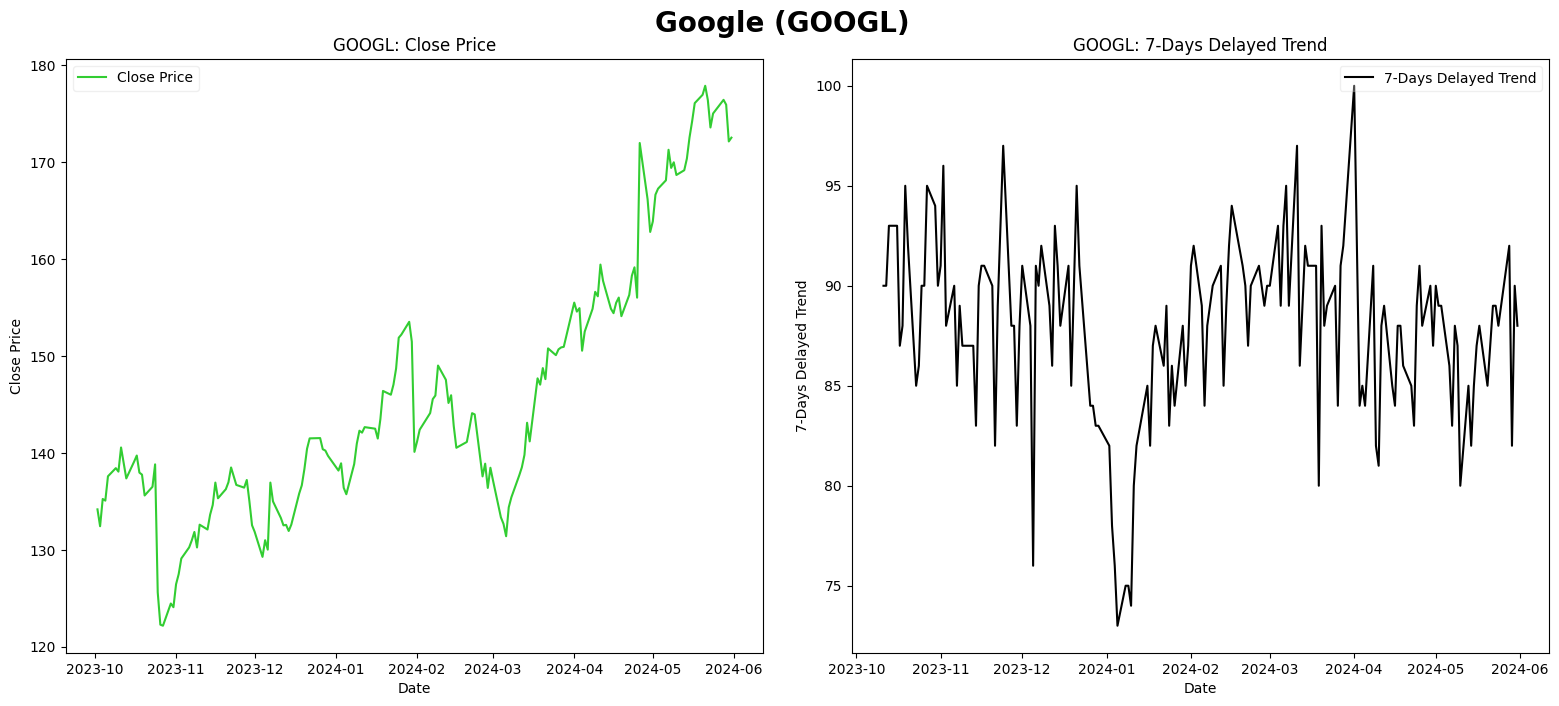

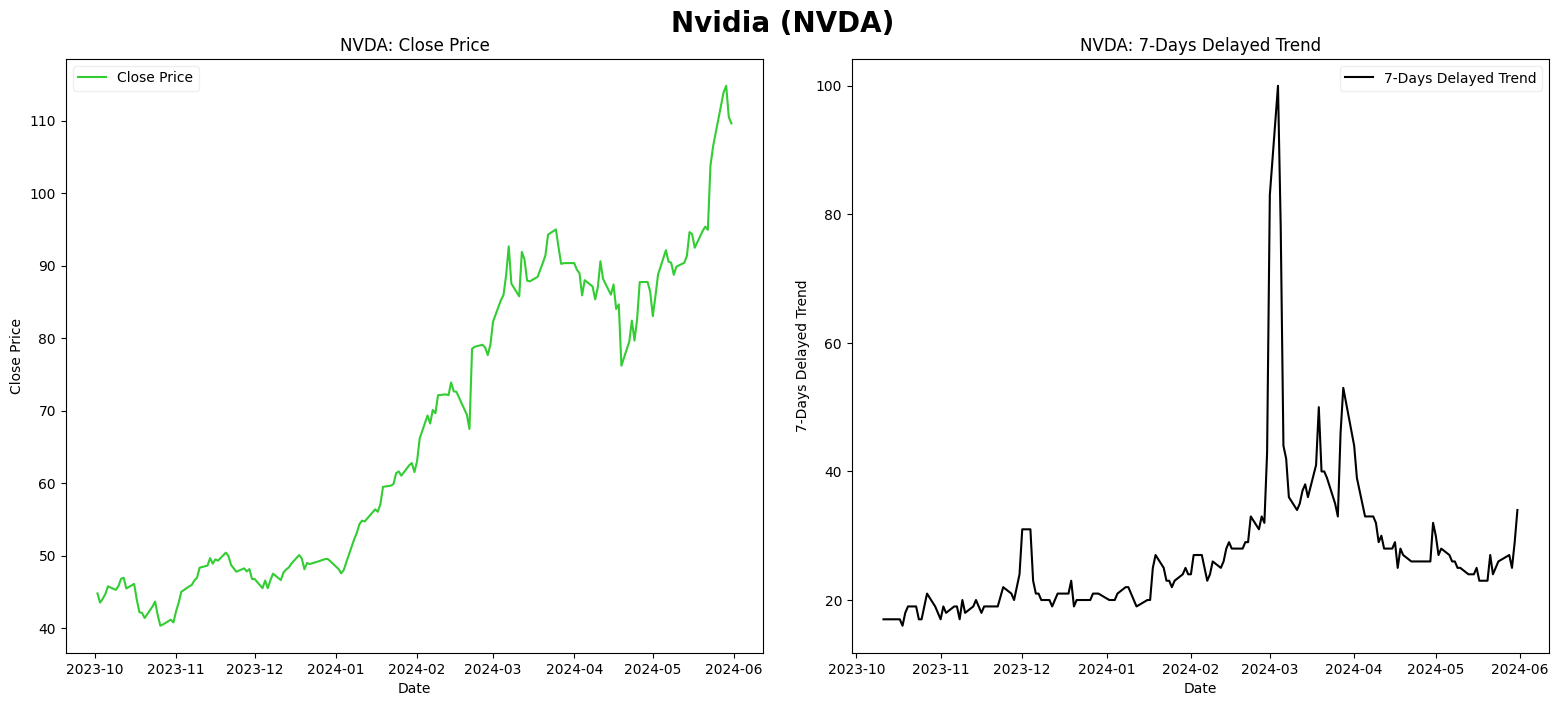

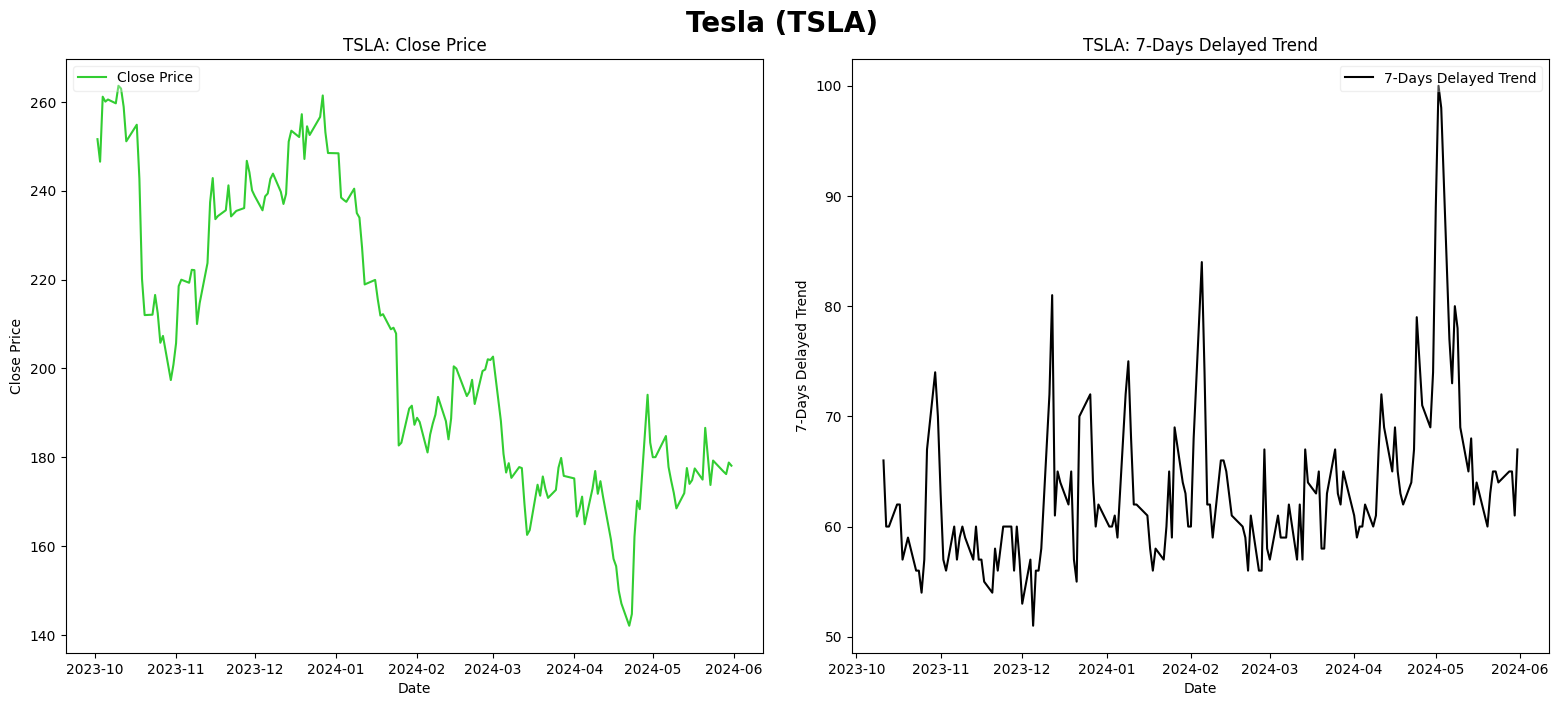

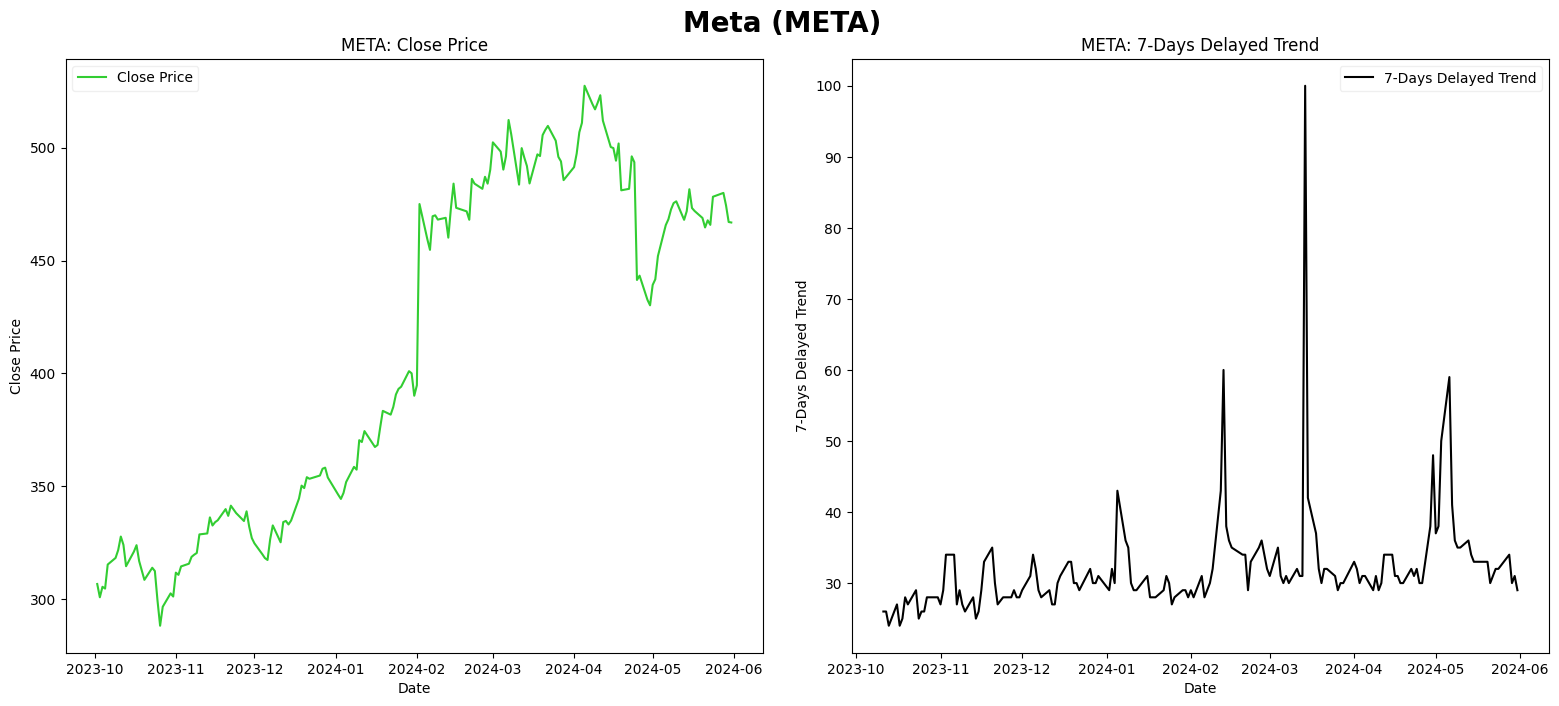

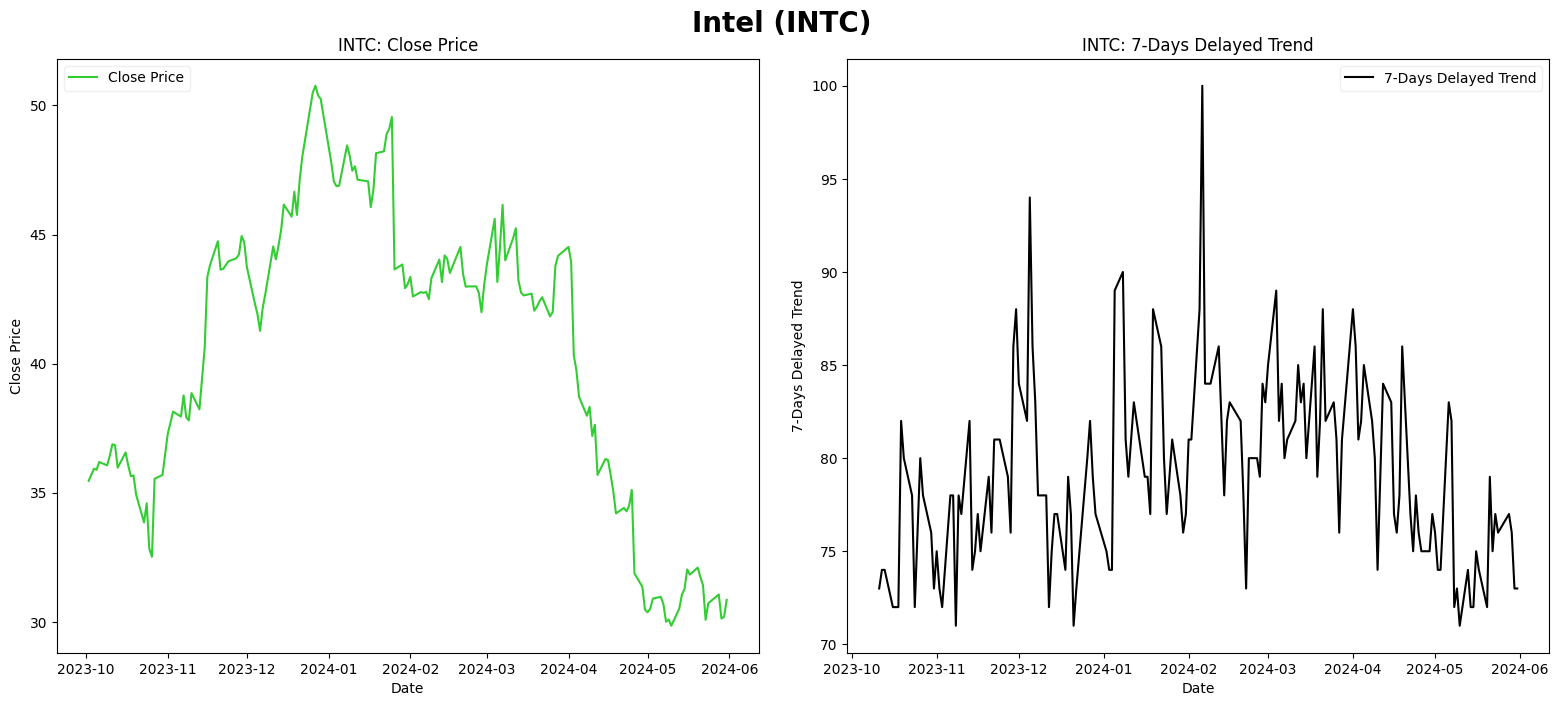

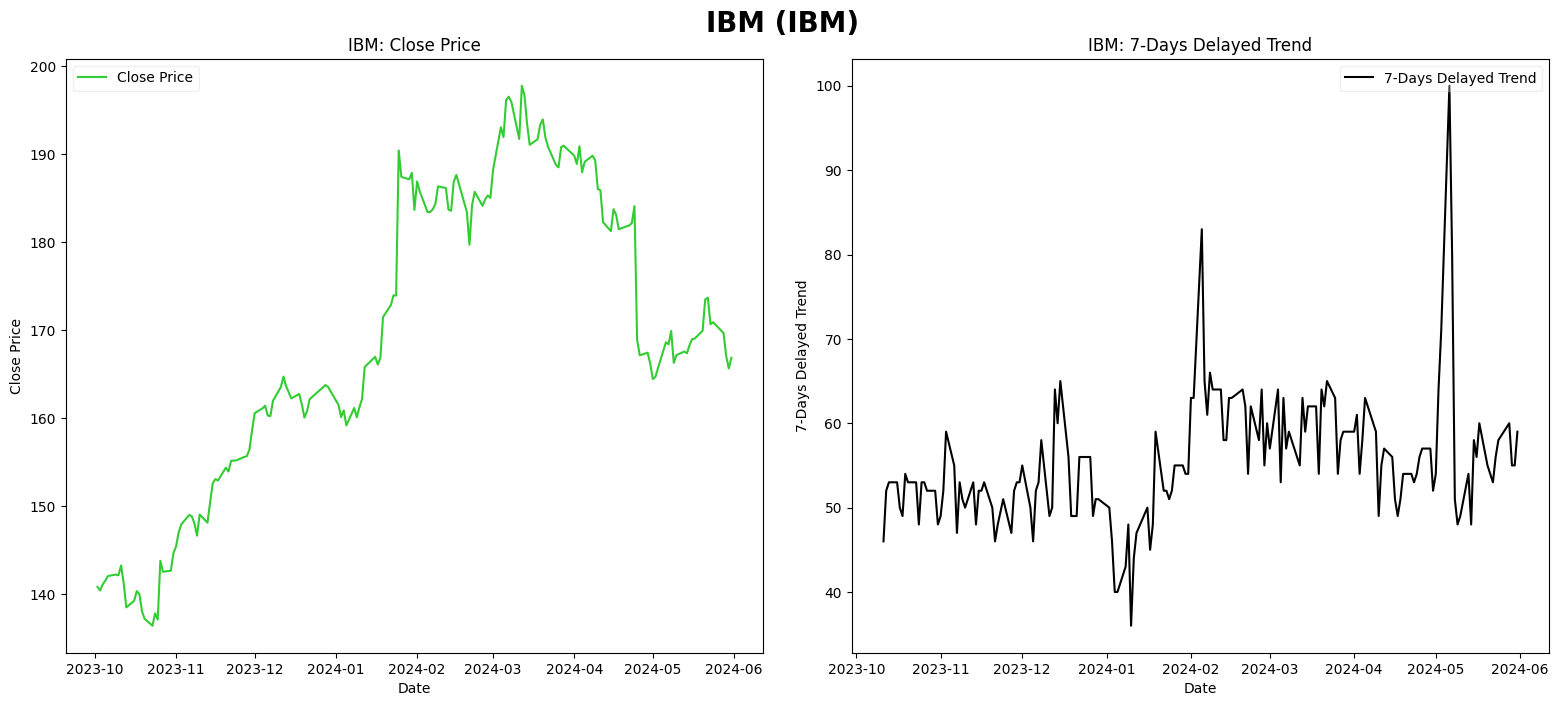

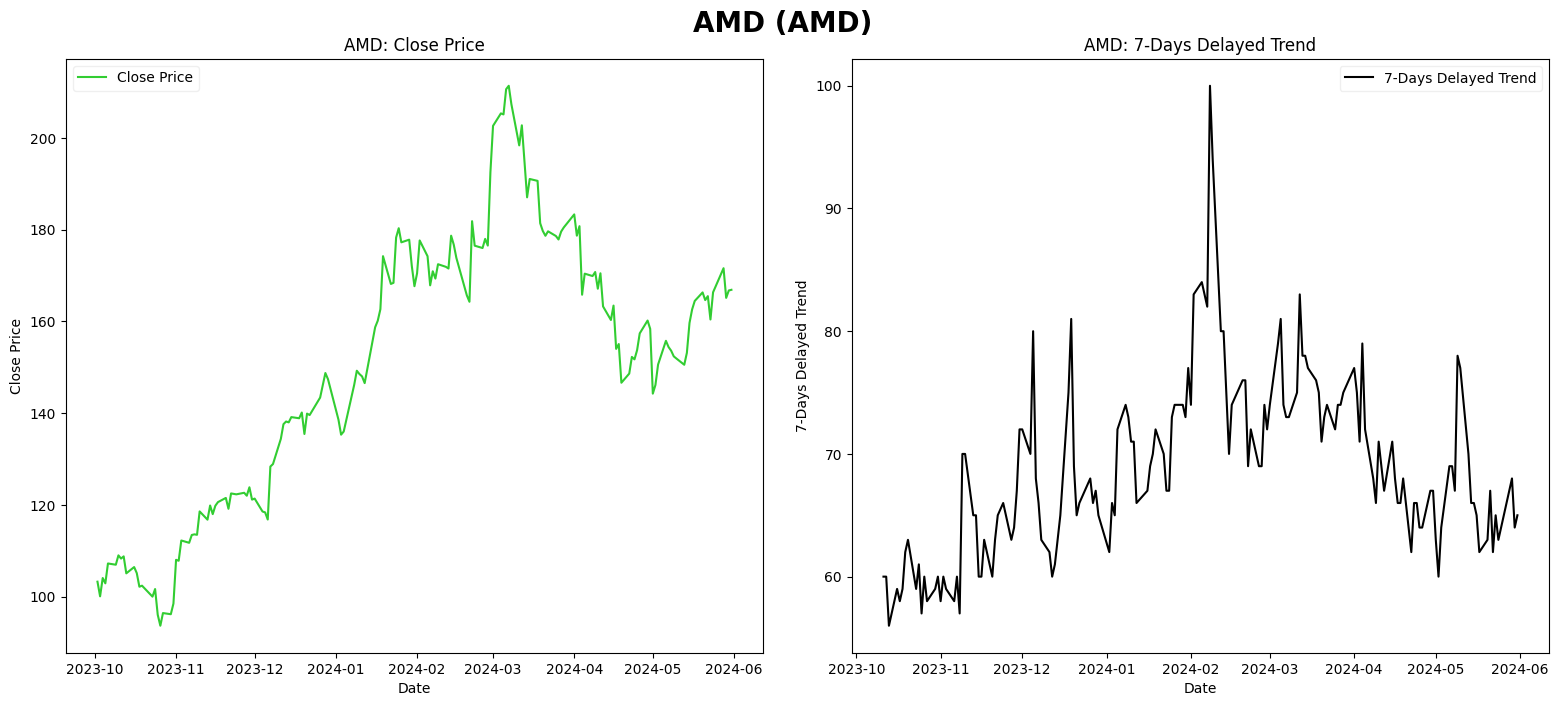

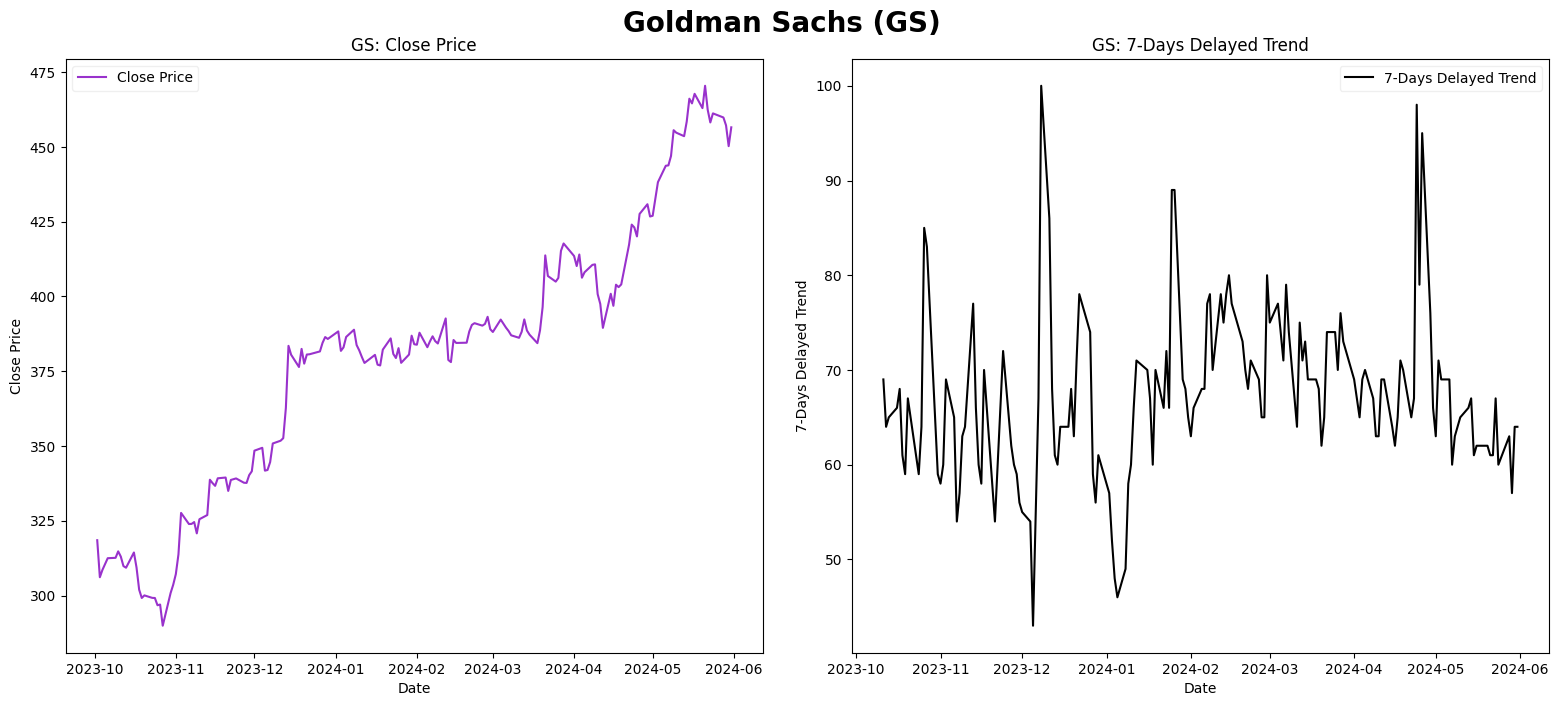

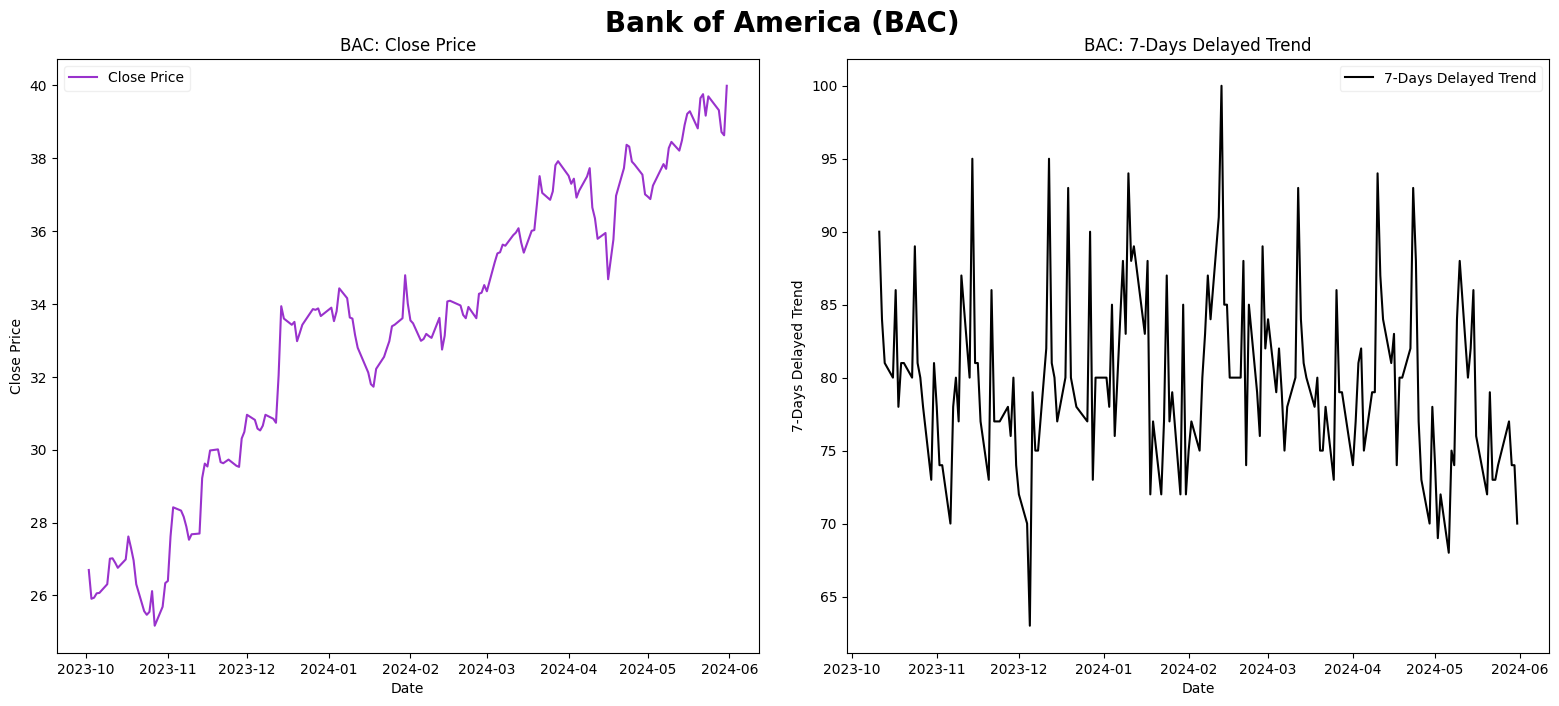

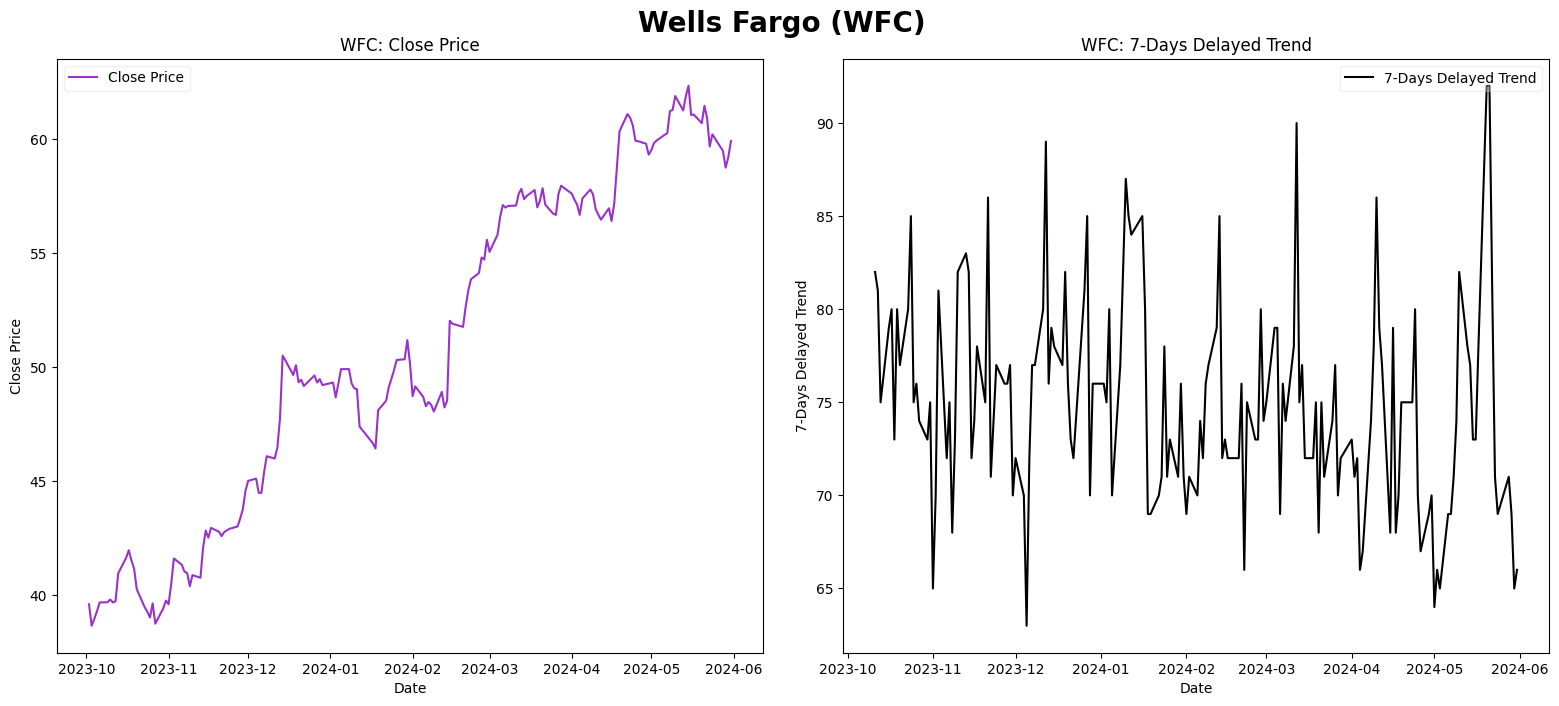

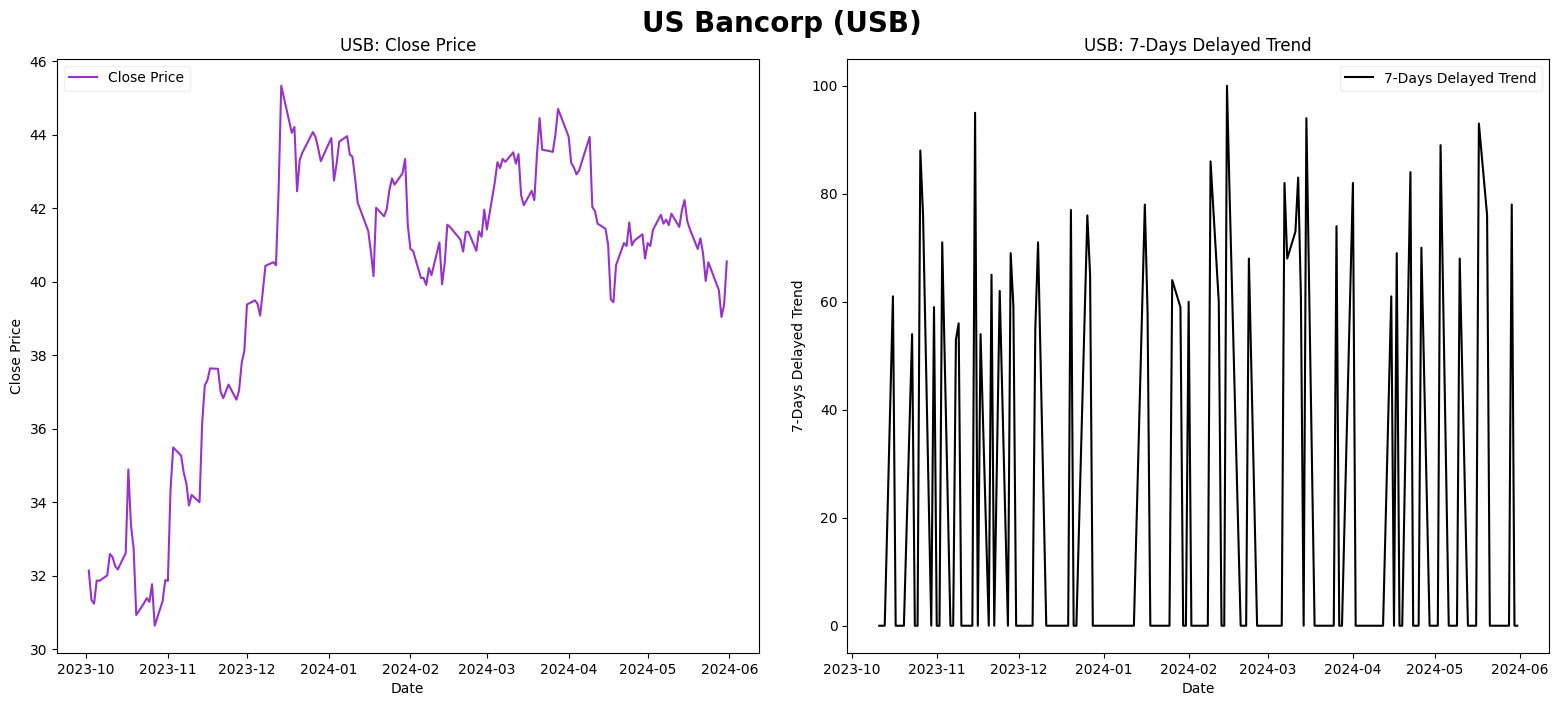

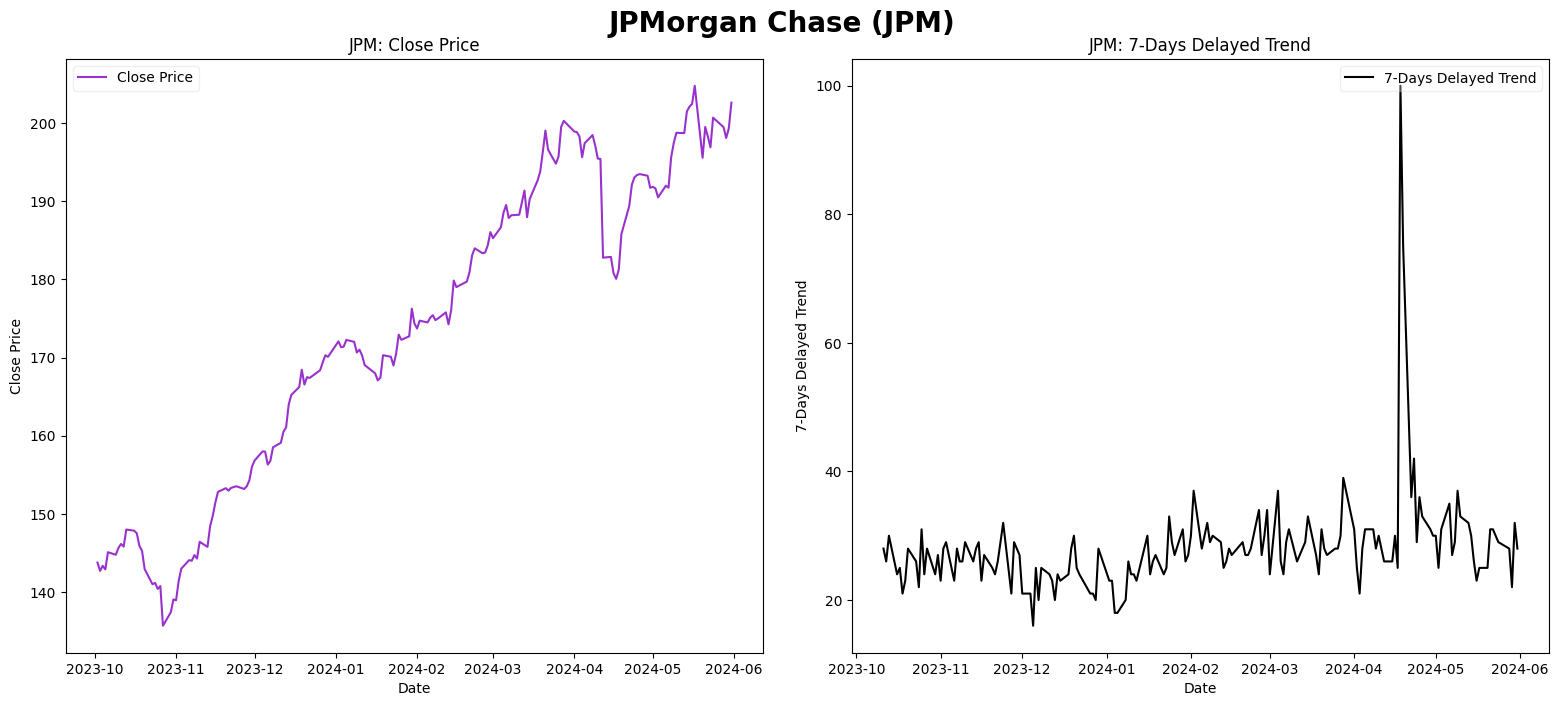

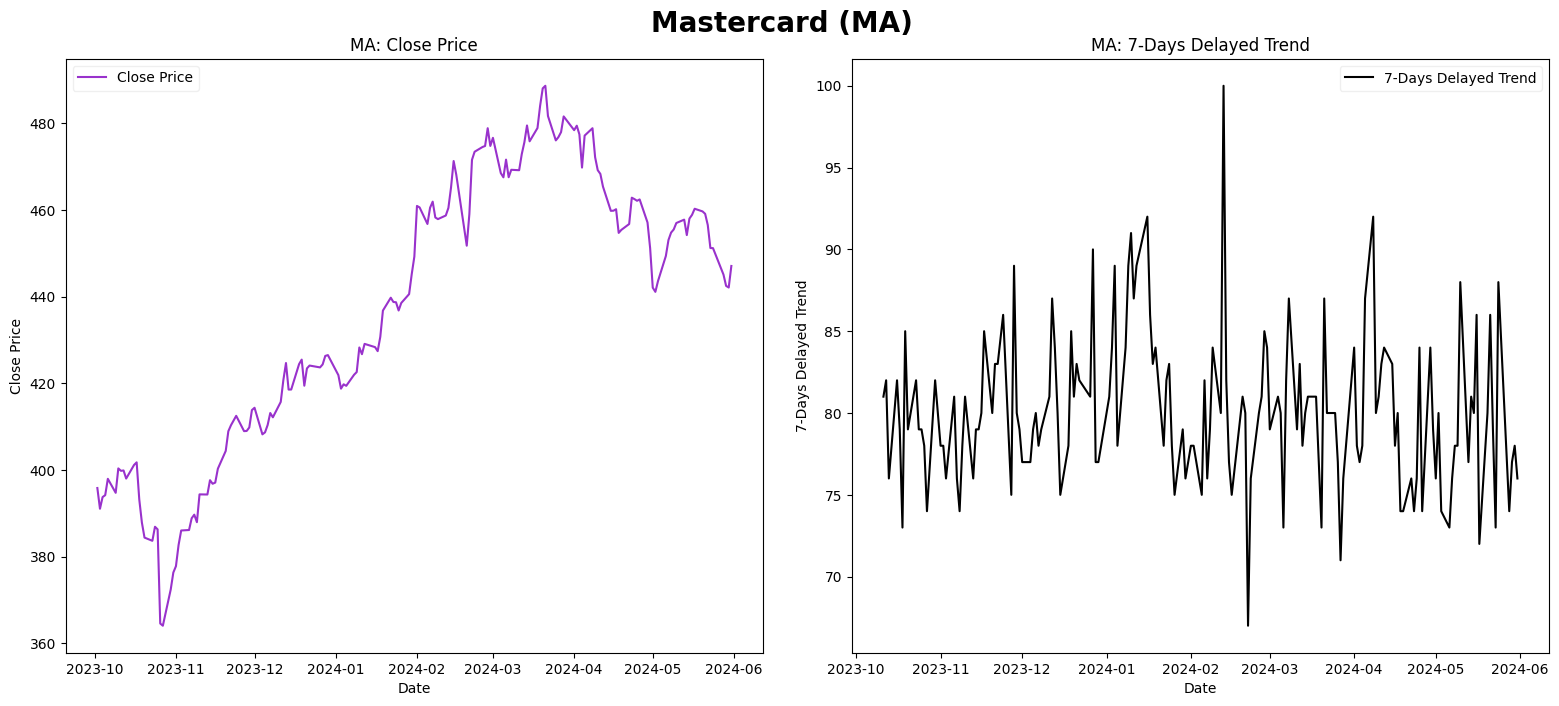

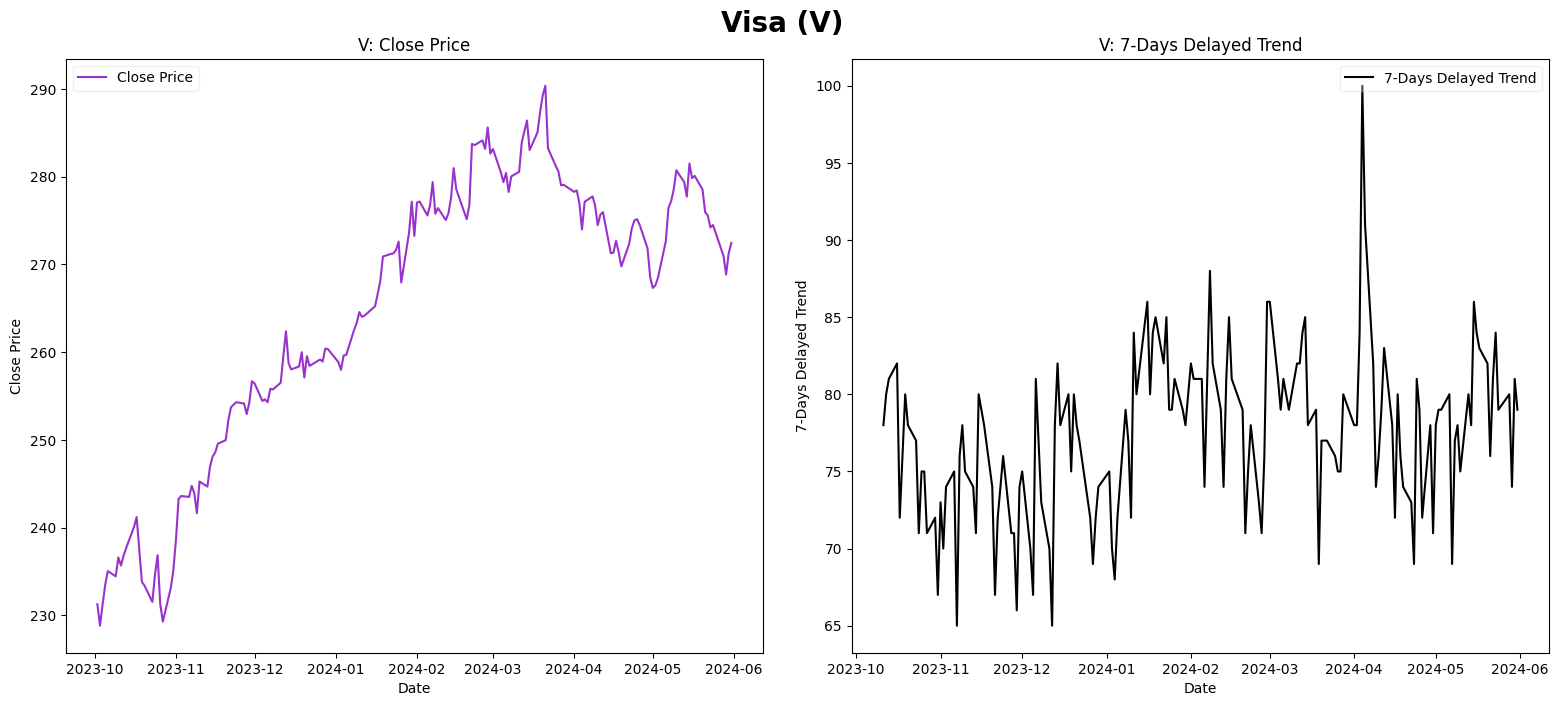

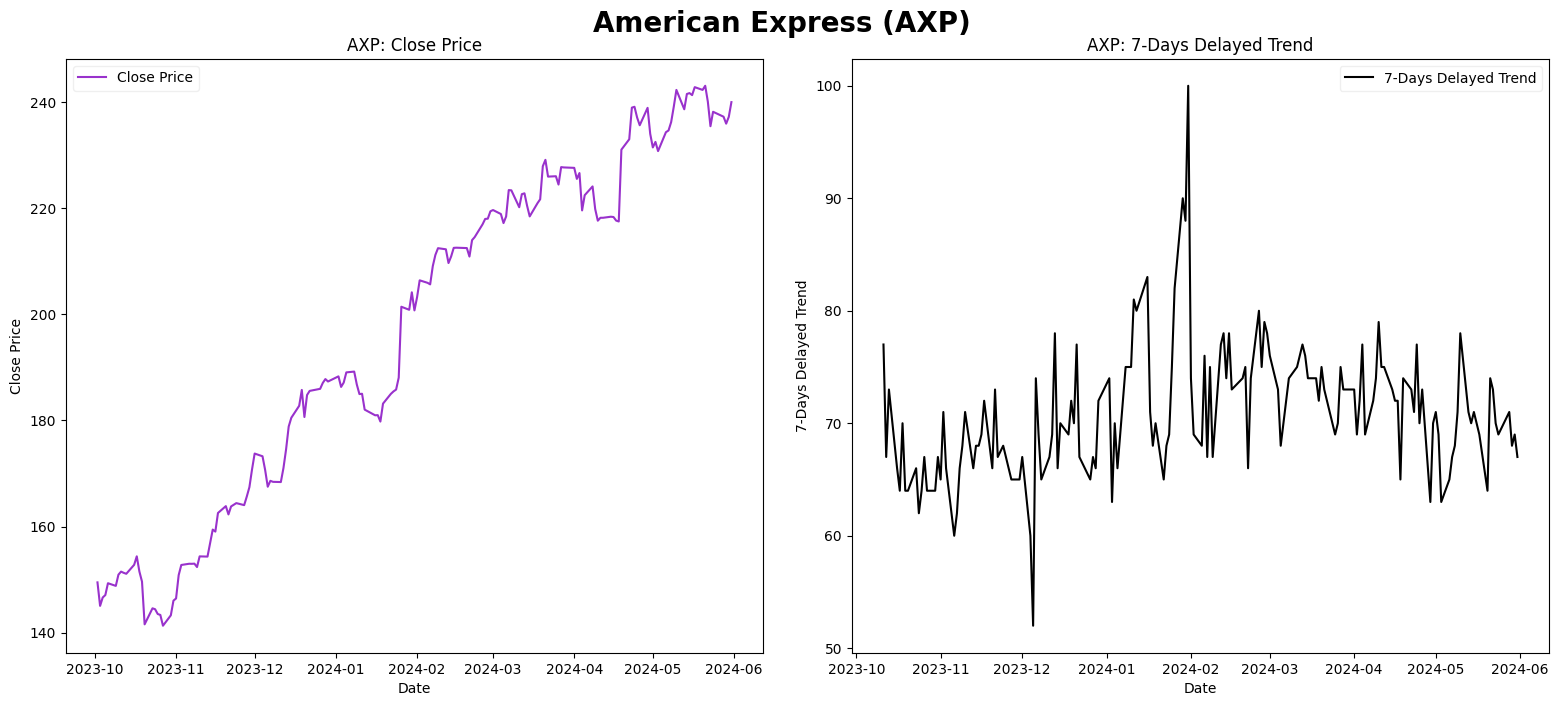

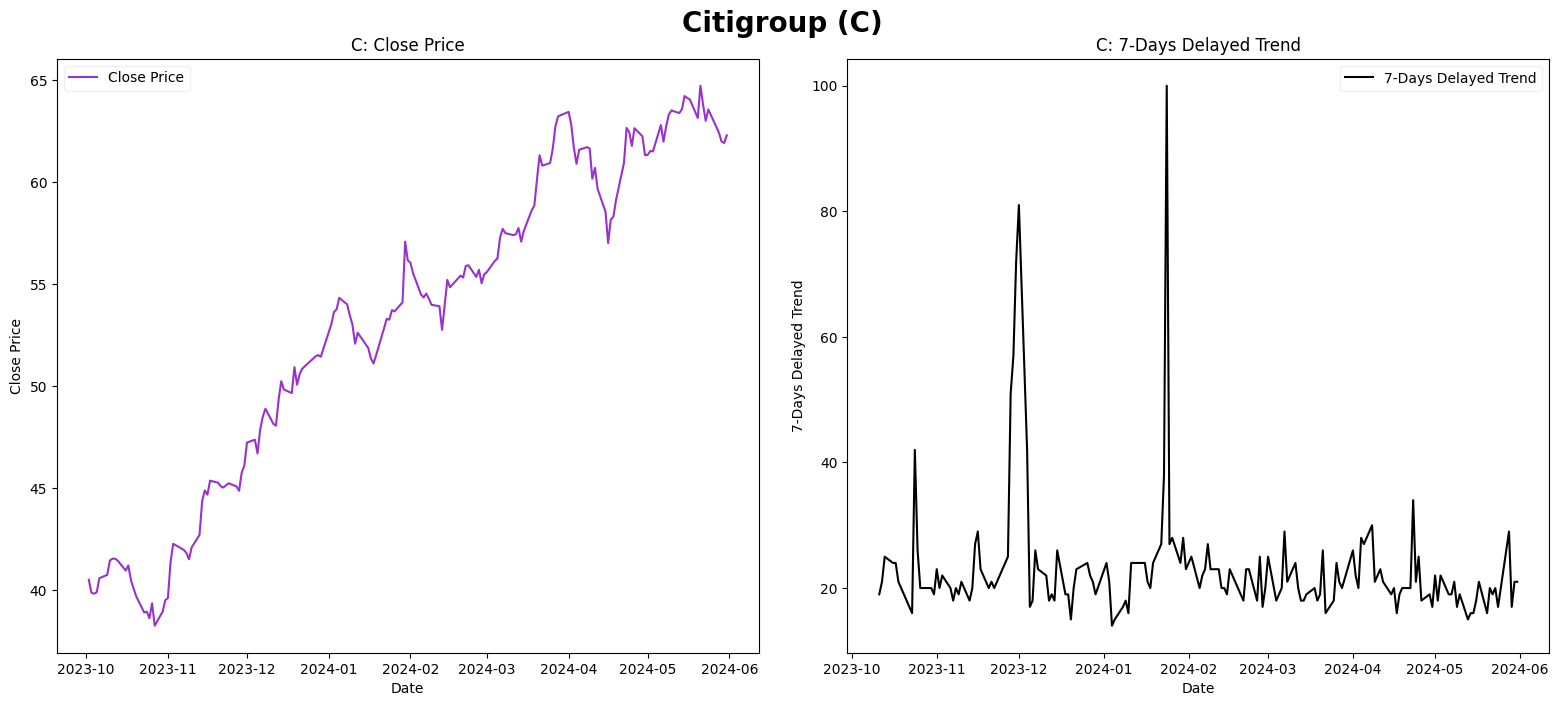

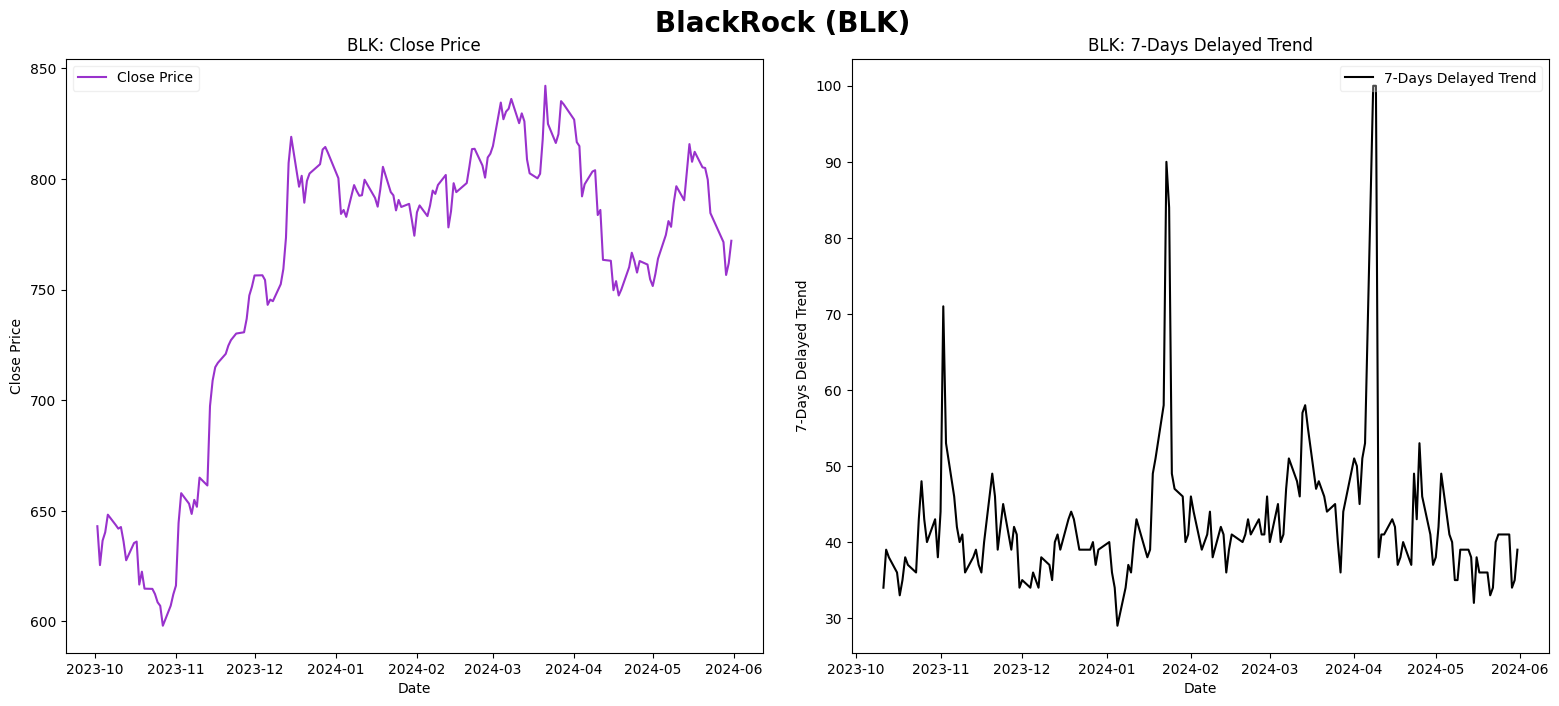

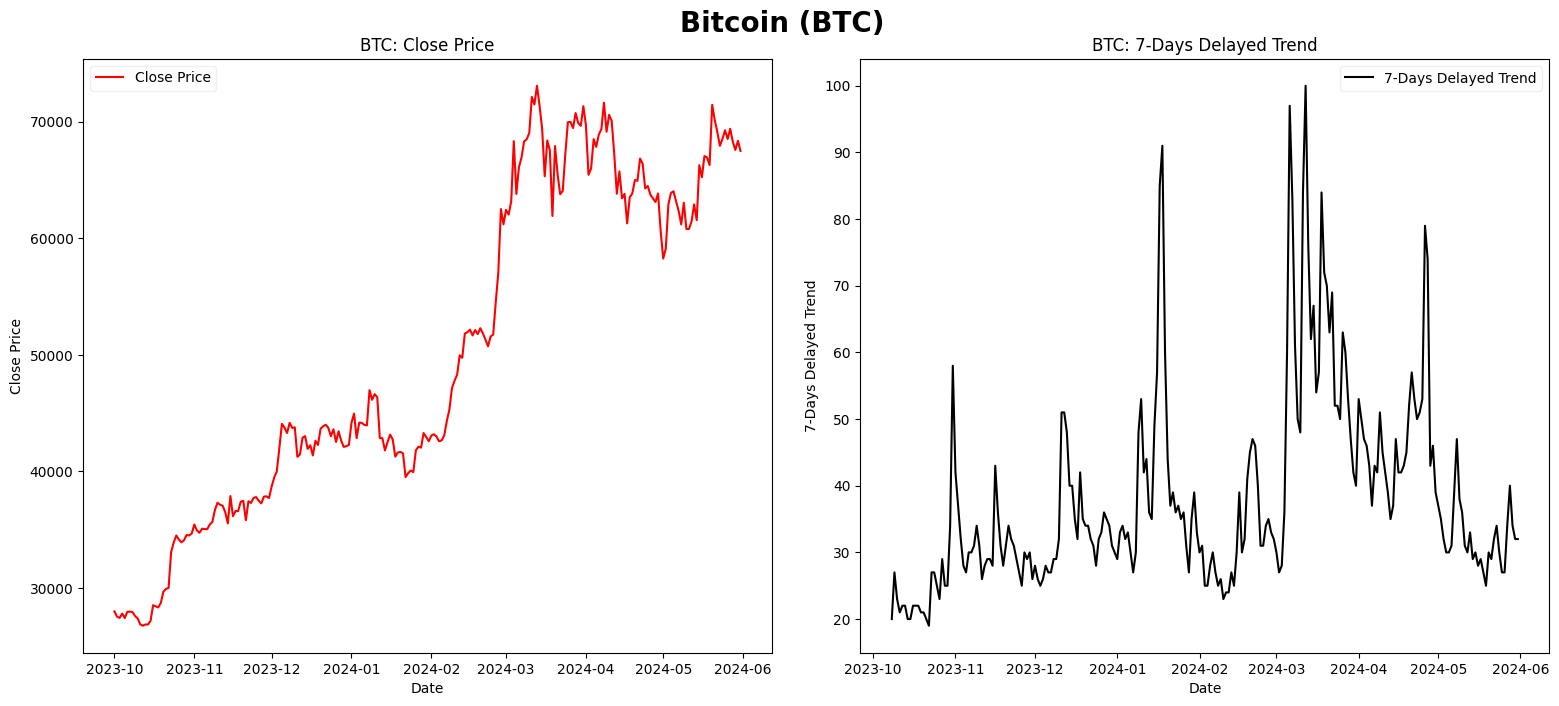

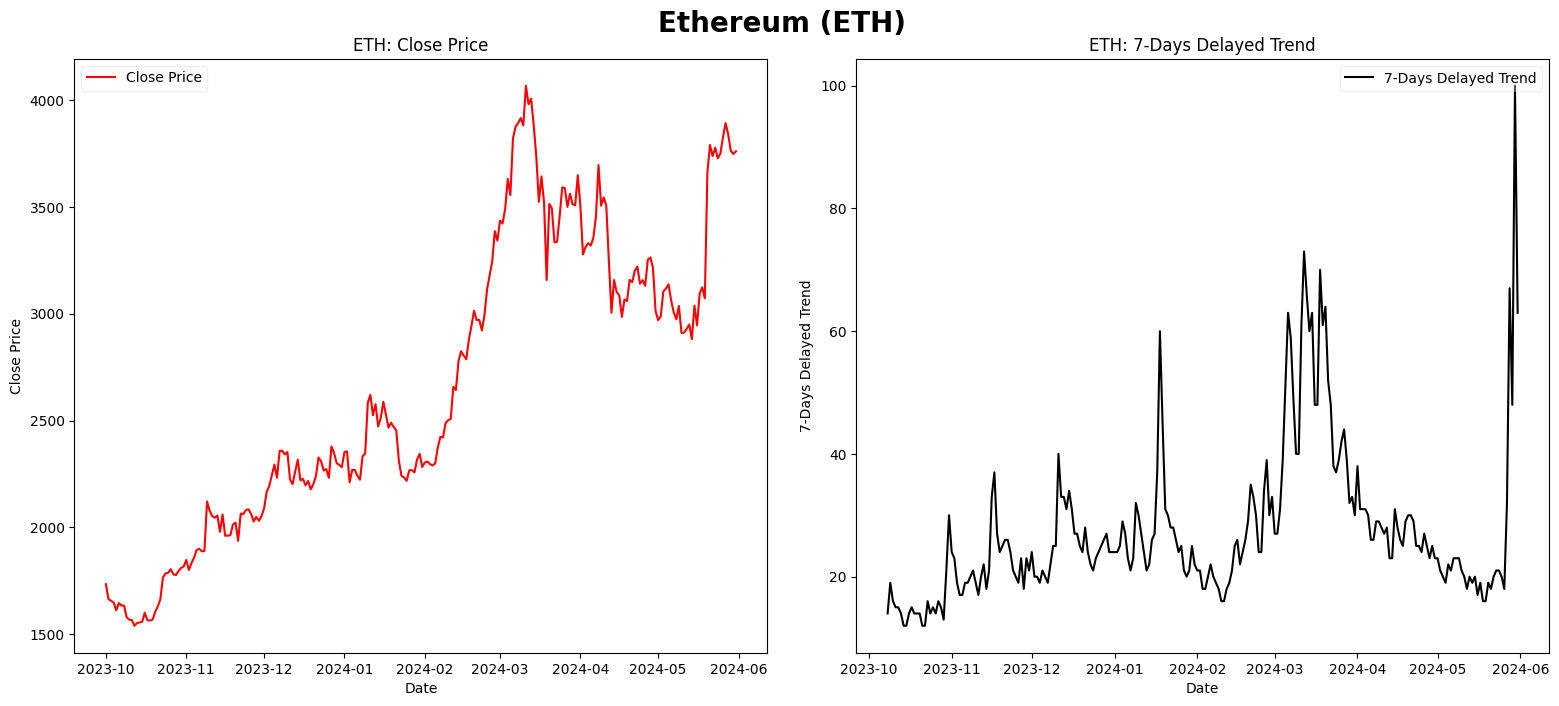

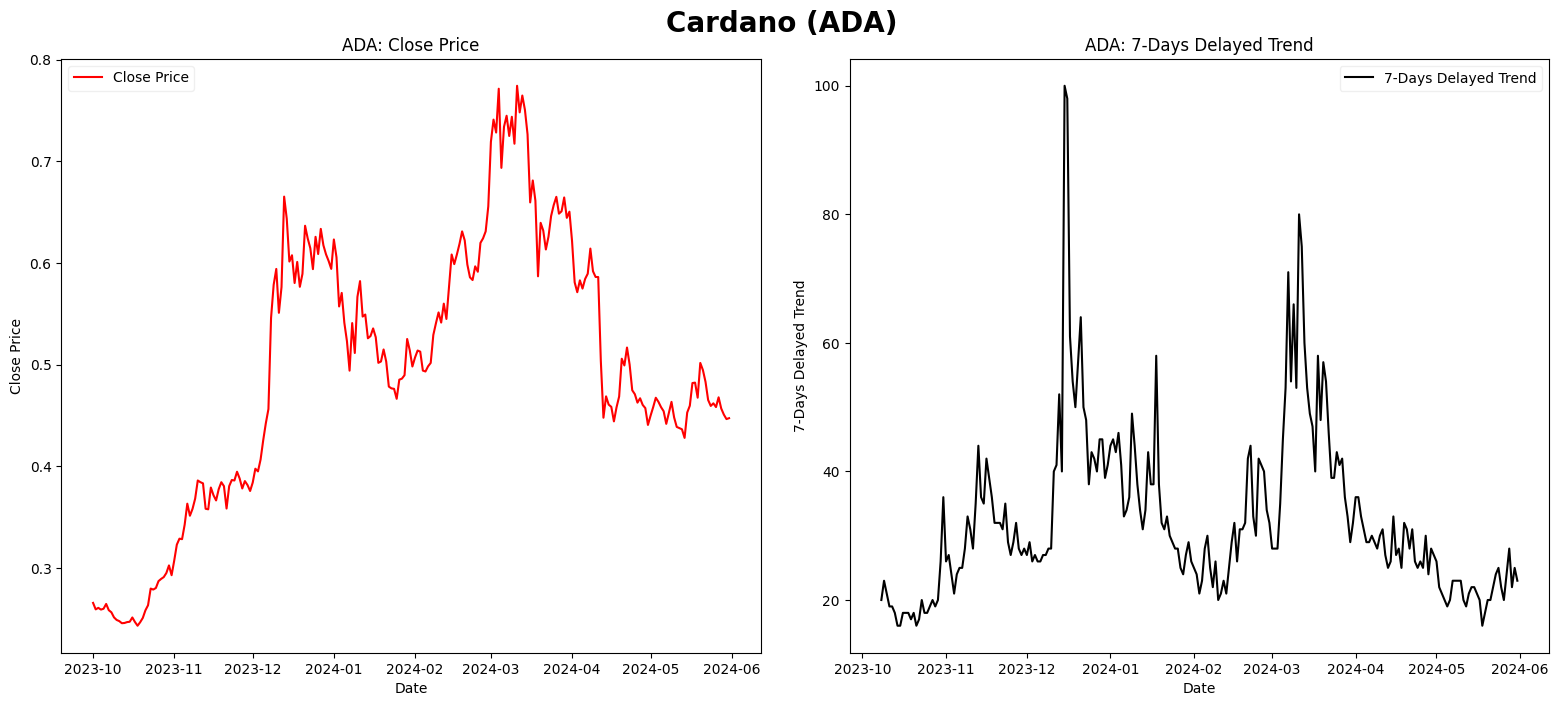

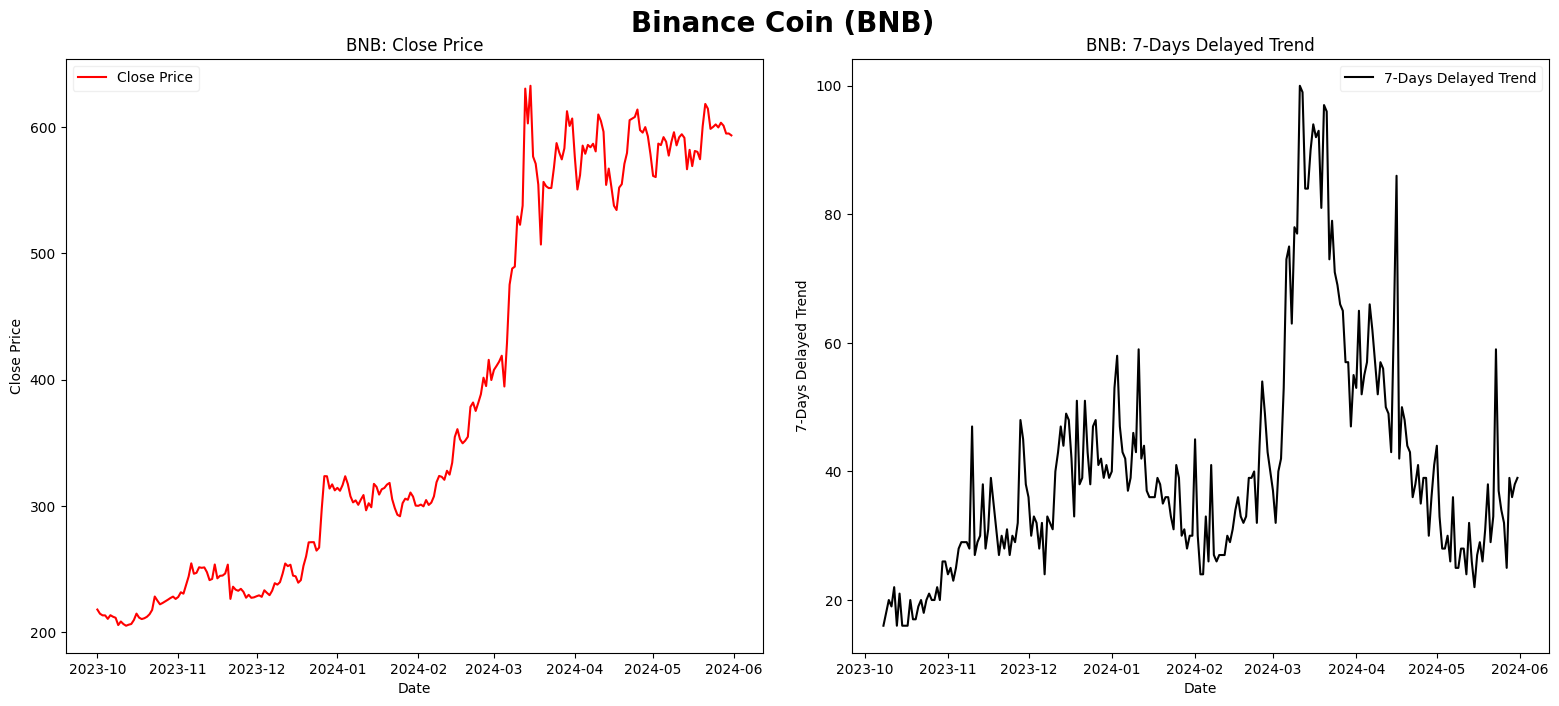

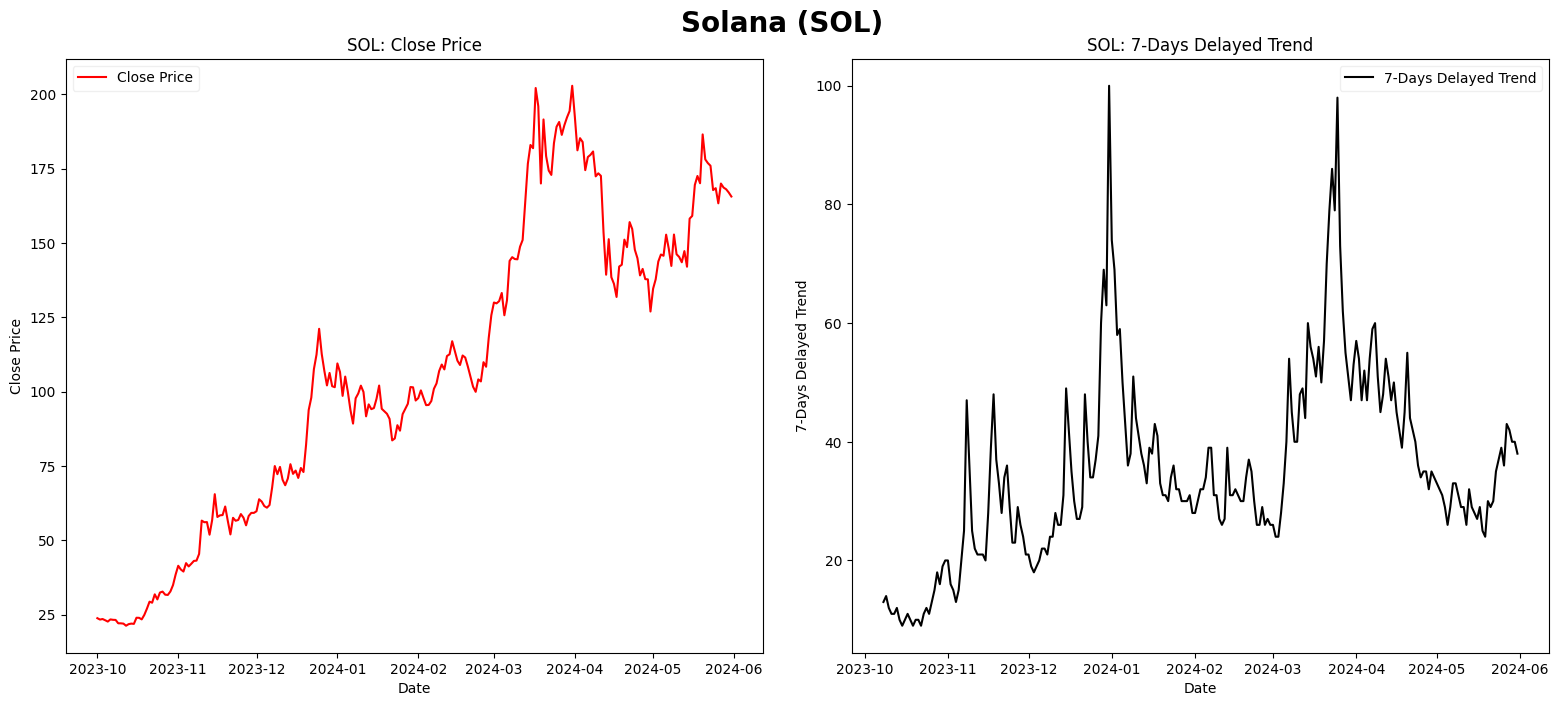

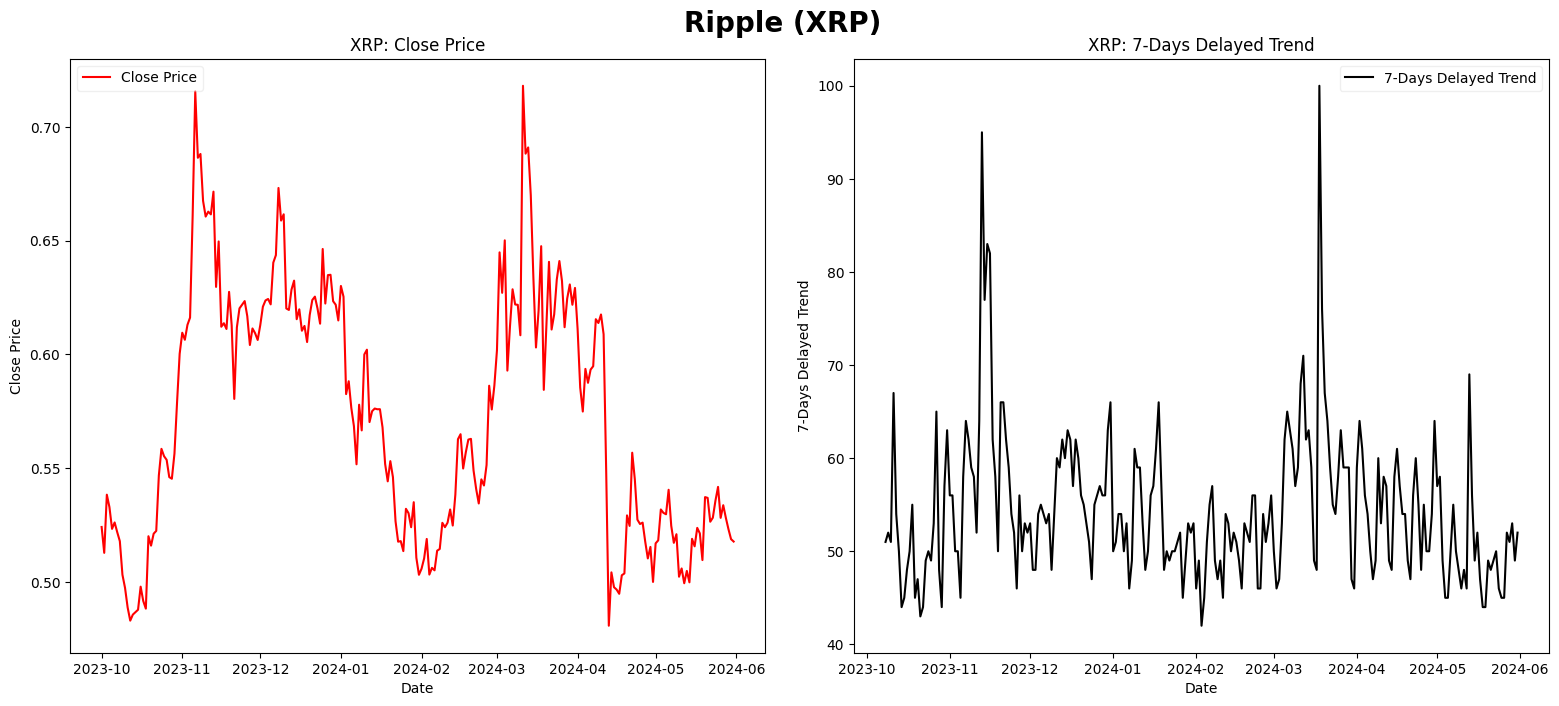

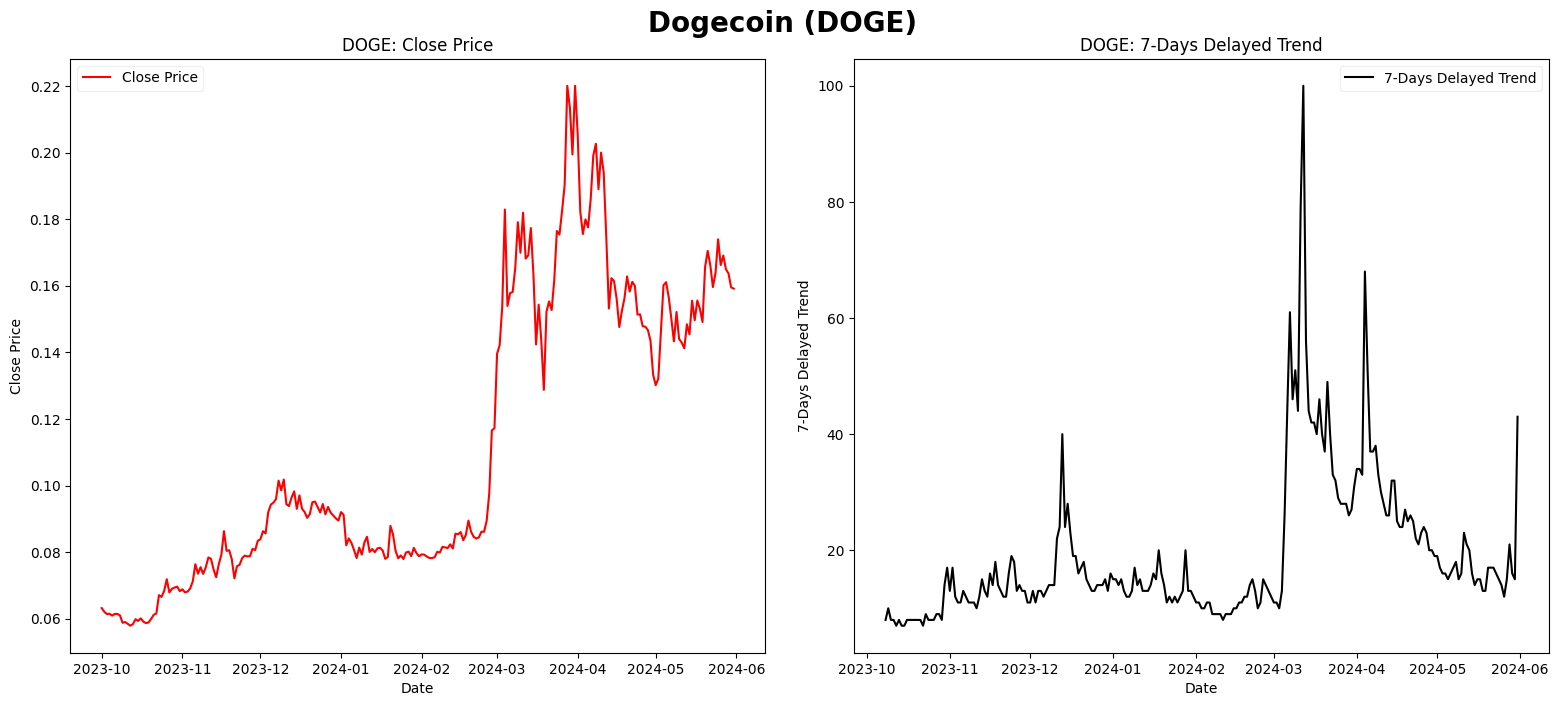

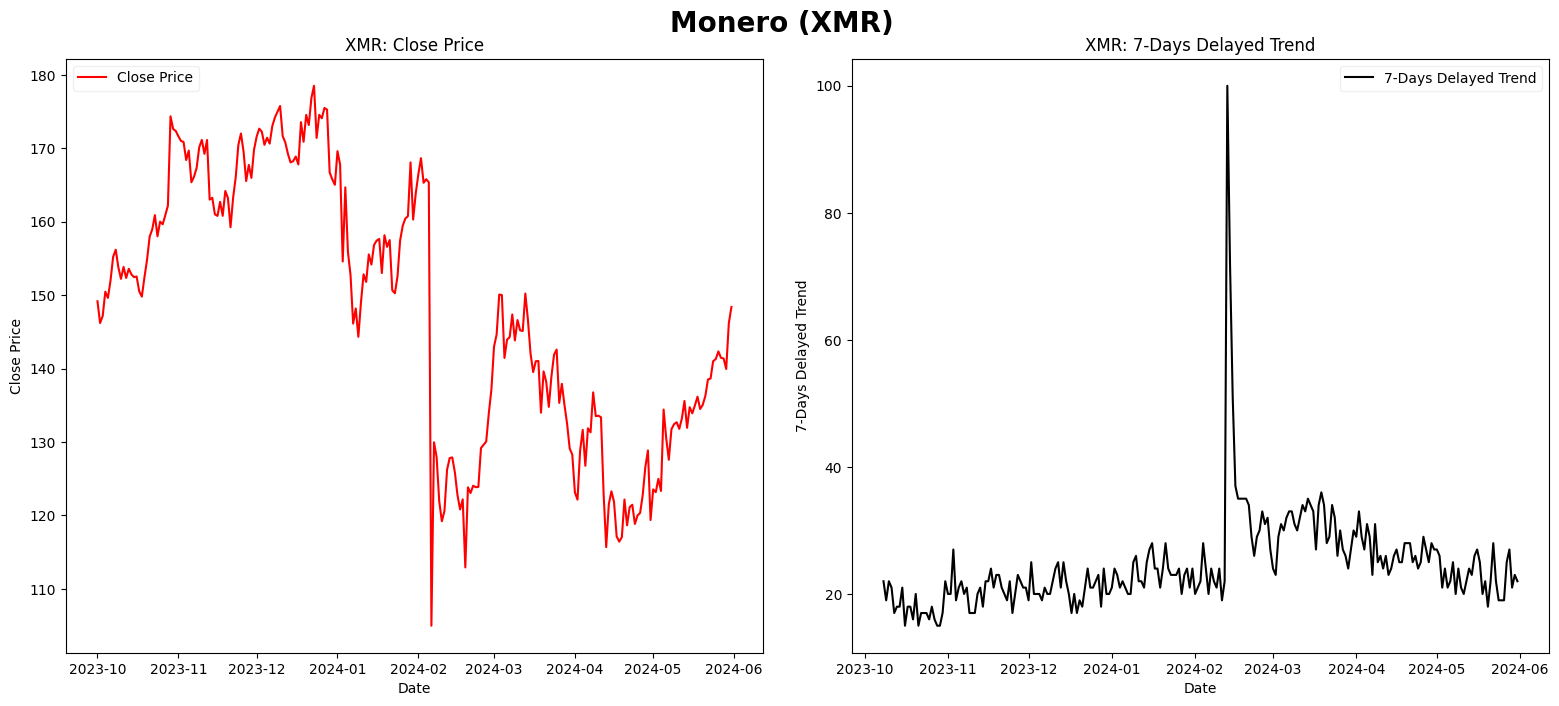

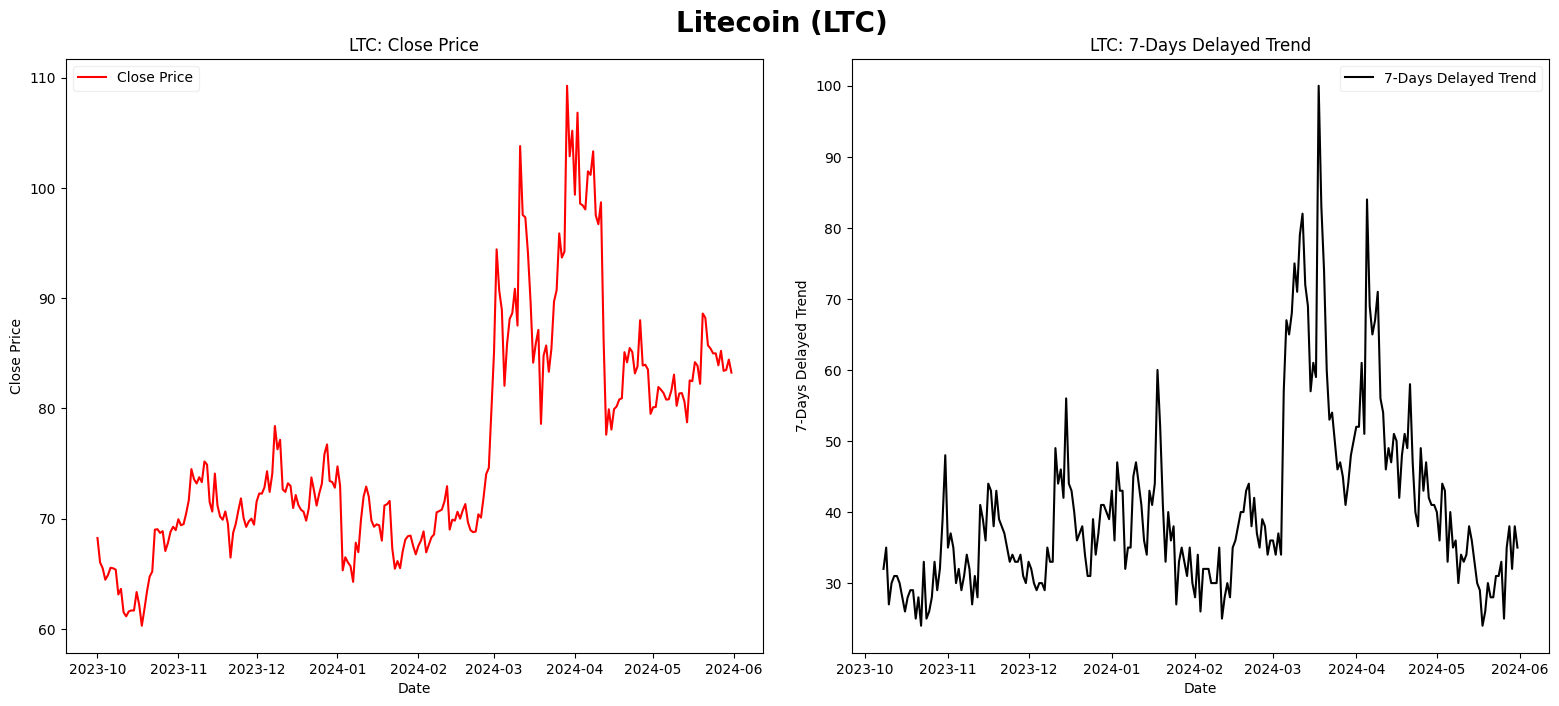

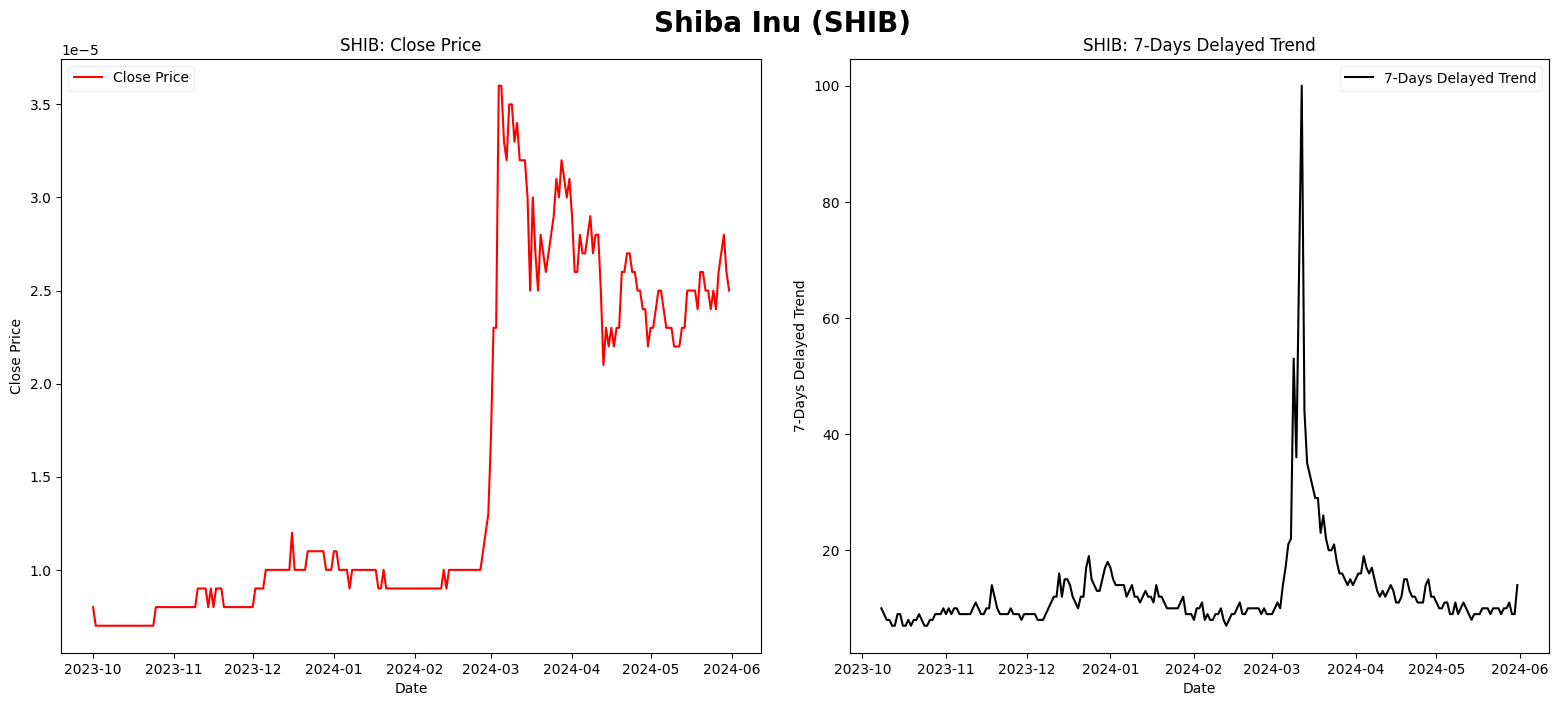

In [45]:
# Plot for each stock and decentralized currency
for stock in general_stocks + tech_stocks + finance_stocks + decentralized_currencies:
    plot_stock_data(stock, download = True)